# Vorhersage von Abstimmungsresultaten

## Maschinelles Lernen auf Basis von Parolen, Parlamentszusammensetzung und Resultate «idealtypischer» Gemeinden

- Martin Sigrist (21-101-175)
- Universität Bern, Institut für Soziologie
- Seminar: Machine Learning for Social Sciences, FS 2023
- Tutor: Sebastian Bahr, M.A.

## Python Bibliotheken laden

In [1]:
# Bibliotheken zu Datenhandling und numerischen Berechnungen
import numpy as np
import pandas as pd
import math

# Bibliotheken zum erstellen von Grafiken
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns

# Funktoinen zur String Bearbeitung
from textwrap import wrap

# k-Means Clustering
from sklearn.cluster import KMeans

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Funktionen zu Imputation
from sklearn.impute import SimpleImputer # univariate Imputation (z.B. Mittelwert, Median, Modus, Konstante)
# from sklearn.impute import IterativeImputer # Multivariate Imputation: Iteratives Verfahren mit allen anderen Variablen (experimentel)
from sklearn.impute import KNNImputer # Nearest-Neighbor Imputation (Standartwert: k=5)


# Funktionen zur Generierung von Zufallszahlen
from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform

# Naive Bayes
from sklearn.naive_bayes import GaussianNB


# Metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Linear Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor

# kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

# Support Vector Machine
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor


# DBSCAN
from sklearn.cluster import DBSCAN

from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


# Ensemble Learning and Stacking
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import StackingRegressor



from xgboost import XGBRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import tree


random_state = 42

## Funktionen definieren

In [2]:
# Code Quelle:
# Géron, Aurélien. 2023: Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems.
# Beijing Boston Farnham Sebastopol Tokyo: O’Reilly.

from pathlib import Path

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ergebnisse Abstimmungen in den Gemeinden

### Abstimmungsergebnisse in den Gemeinden für die Jahre 1990 bis 1999

In [3]:
df_Gemeinden_90_99 = pd.read_csv("BFS-Abstimmungen_CH_1990-1999 - cleaned.csv", sep=";", na_values="...")

# Leere Zellen für Einheit-Nr. füllen mit letztem vorhandenem Wert
df_Gemeinden_90_99["Einheit"] = df_Gemeinden_90_99.Einheit.fillna(method="ffill", axis=0)

# Leere Zellen für Bezeichnung füllen mit letztem vorhandenem Wert
df_Gemeinden_90_99["Bezeichnung"] = df_Gemeinden_90_99["Bezeichnung"].fillna(method="ffill", axis=0)

# Auswahl der Resultate in den Gemeinden (entfernen der Ebenen Nation, Kanton und Bezirk)
df_Gemeinden_90_99 = df_Gemeinden_90_99.query('Bezeichnung.str.startswith("......")', engine="python")

# Zeilen mit fehlenden Werten entfernen
df_Gemeinden_90_99 = df_Gemeinden_90_99.dropna()

# Anteil Ja-Stimmen berechnen (gerundet auf 3 Nachkommastellen)
df_Gemeinden_90_99["Zustimmung"] = (df_Gemeinden_90_99["Ja"]/df_Gemeinden_90_99["Stimmen"]).round(3)

# Führende zeichen in Bezeichnung entfernen
df_Gemeinden_90_99['Bezeichnung'] = df_Gemeinden_90_99.Bezeichnung.str.removeprefix('......')

df_Gemeinden_90_99.sort_values(by = ['Einheit', 'Abstimmung'])

,Einheit,Bezeichnung,Abstimmung,Titel,Berechtigte,Stimmen,Ja,Zustimmung
399,0001,Aeugst am Albis,3590,1990-04-01 Volksinitiative «Stopp dem Beton - ...,801.0,590.0,154.0,0.261
398,0001,Aeugst am Albis,3600,1990-04-01 Volksinitiative «für eine autobahnf...,801.0,589.0,216.0,0.367
397,0001,Aeugst am Albis,3610,1990-04-01 Volksinitiative «für ein autobahnfr...,801.0,592.0,209.0,0.353
396,0001,Aeugst am Albis,3620,1990-04-01 Volksinitiative «für eine freie Aar...,801.0,576.0,212.0,0.368
395,0001,Aeugst am Albis,3630,1990-04-01 Bundesbeschluss über den Rebbau,801.0,561.0,219.0,0.390
...,...,...,...,...,...,...,...,...
233504,9250,GE-CH de l'étranger,4540,1999-06-13 Asylgesetz,6946.0,3196.0,1805.0,0.565
233503,9250,GE-CH de l'étranger,4550,1999-06-13 Bundesbeschluss über dringliche Mas...,6946.0,3178.0,1774.0,0.558
233502,9250,GE-CH de l'étranger,4560,1999-06-13 Bundesbeschluss über die ärztliche ...,6946.0,3208.0,2127.0,0.663
233501,9250,GE-CH de l'étranger,4570,1999-06-13 Bundesgesetz über die Invalidenvers...,6946.0,3197.0,910.0,0.285


In [4]:
# Data Frame mit Gemeindenummer und Abstimmungsresultaten generieren
df_Gemeinden_90_99_Resultate = df_Gemeinden_90_99.pivot(index="Einheit", columns="Abstimmung", values="Zustimmung").reset_index().rename_axis(None, axis=1)
df_Gemeinden_90_99_Resultate

,Einheit,3590,3600,3610,3620,3630,3640,3650,3660,3670,...,4490,4500,4510,4520,4530,4540,4550,4560,4570,4580
0,0001,0.261,0.367,0.353,0.368,0.390,0.482,0.473,0.551,0.684,...,0.775,0.856,0.564,0.529,0.569,0.718,0.726,0.683,0.327,0.407
1,0002,0.256,0.306,0.309,0.318,0.358,0.422,0.449,0.511,0.671,...,0.793,0.860,0.464,0.550,0.489,0.737,0.741,0.594,0.329,0.313
2,0003,0.398,0.528,0.541,0.529,0.336,0.394,0.492,0.567,0.704,...,0.795,0.873,0.546,0.549,0.603,0.751,0.751,0.674,0.329,0.409
3,0004,0.269,0.322,0.311,0.343,0.351,0.446,0.507,0.564,0.674,...,0.755,0.833,0.577,0.501,0.525,0.685,0.668,0.630,0.299,0.380
4,0005,0.288,0.363,0.362,0.372,0.341,0.411,0.447,0.506,0.655,...,0.789,0.855,0.510,0.506,0.558,0.737,0.737,0.648,0.329,0.385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,6808,0.133,0.094,0.108,0.086,0.543,0.313,0.557,0.657,0.737,...,0.418,0.827,0.289,0.614,0.816,0.481,0.467,0.436,0.227,0.693
2137,6809,0.156,0.144,0.175,0.144,0.584,0.368,0.557,0.710,0.760,...,0.423,0.872,0.303,0.556,0.696,0.503,0.516,0.438,0.222,0.744
2138,6810,0.160,0.133,0.133,0.120,0.533,0.370,0.456,0.473,0.693,...,0.450,0.843,0.401,0.632,0.627,0.545,0.525,0.413,0.255,0.651
2139,9030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.866,0.932,0.230,0.676,0.910,0.735,0.737,0.670,0.567,0.686


In [5]:
# Data Frame mit Gemeindenummer und Mittelwert der Anzahl Stimmberechtigten generieren
df_Gemeinden_90_99_Berechtigte = pd.DataFrame(df_Gemeinden_90_99.groupby('Einheit')['Berechtigte'].mean().round()).reset_index().rename_axis(None, axis=1)
df_Gemeinden_90_99_Berechtigte

,Einheit,Berechtigte
0,0001,963.0
1,0002,5690.0
2,0003,2206.0
3,0004,1931.0
4,0005,1652.0
...,...,...
2136,6808,992.0
2137,6809,931.0
2138,6810,964.0
2139,9030,2323.0


In [6]:
# Data Frame mit Gemeindenummer und Gemeindename generieren
df_Gemeinden_90_99_Name = pd.DataFrame({'Einheit': df_Gemeinden_90_99.Einheit.unique(), 'Bezeichnung': df_Gemeinden_90_99.Bezeichnung.unique()}).sort_values(by = 'Einheit')
df_Gemeinden_90_99_Name

,Einheit,Bezeichnung
0,0001,Aeugst am Albis
1,0002,Affoltern am Albis
2,0003,Bonstetten
3,0004,Hausen am Albis
4,0005,Hedingen
...,...,...
2138,6808,Clos du Doubs
2139,6809,Haute-Ajoie
2140,6810,La Baroche
574,9030,LU-Ausland-CH


In [7]:
# Data Frame mit den Abstimmungen aus den Jahren 1990 bis 1999
df_Abstimmungen_90_99 = pd.DataFrame({'Abstimmung': df_Gemeinden_90_99.Abstimmung.unique(), 'Titel': df_Gemeinden_90_99.Titel.unique()}).sort_values(by = 'Abstimmung').reset_index().drop(columns='index')
df_Abstimmungen_90_99

,Abstimmung,Titel
0,3590,1990-04-01 Volksinitiative «Stopp dem Beton - ...
1,3600,1990-04-01 Volksinitiative «für eine autobahnf...
2,3610,1990-04-01 Volksinitiative «für ein autobahnfr...
3,3620,1990-04-01 Volksinitiative «für eine freie Aar...
4,3630,1990-04-01 Bundesbeschluss über den Rebbau
...,...,...
95,4540,1999-06-13 Asylgesetz
96,4550,1999-06-13 Bundesbeschluss über dringliche Mas...
97,4560,1999-06-13 Bundesbeschluss über die ärztliche ...
98,4570,1999-06-13 Bundesgesetz über die Invalidenvers...


### Abstimmungsergebnisse in den Gemeinden für die Jahre 2000 bis 2009

In [8]:
df_Gemeinden_00_09 = pd.read_csv("BFS-Abstimmungen_CH_2000-2009 - cleaned.csv", sep=";", na_values="...")

# Leere Zellen für Einheit-Nr. füllen mit letztem vorhandenem Wert
df_Gemeinden_00_09["Einheit"] = df_Gemeinden_00_09.Einheit.fillna(method="ffill", axis=0)

# Leere Zellen für Bezeichnung füllen mit letztem vorhandenem Wert
df_Gemeinden_00_09["Bezeichnung"] = df_Gemeinden_00_09["Bezeichnung"].fillna(method="ffill", axis=0)

# Auswahl der Resultate in den Gemeinden (entfernen der Ebenen Nation, Kanton und Bezirk)
df_Gemeinden_00_09 = df_Gemeinden_00_09.query('Bezeichnung.str.startswith("......")', engine="python")

# Zeilen mit fehlenden Werten entfernen
df_Gemeinden_00_09 = df_Gemeinden_00_09.dropna()

# Anteil Ja-Stimmen berechnen (gerundet auf 3 Nachkommastellen)
df_Gemeinden_00_09["Zustimmung"] = (df_Gemeinden_00_09["Ja"]/df_Gemeinden_00_09["Stimmen"]).round(3)

# Führende zeichen in Bezeichnung entfernen
df_Gemeinden_00_09['Bezeichnung'] = df_Gemeinden_00_09.Bezeichnung.str.removeprefix('......')

df_Gemeinden_00_09.sort_values(by = ['Einheit', 'Abstimmung'])

,Einheit,Bezeichnung,Abstimmung,Titel,Berechtigte,Stimmen,Ja,Zustimmung
371,0001,Aeugst am Albis,4590,2000-03-12 Bundesbeschluss über die Justizreform,1089.0,509.0,428.0,0.841
370,0001,Aeugst am Albis,4600,2000-03-12 Volksinitiative «für Beschleunigung...,1089.0,514.0,167.0,0.325
369,0001,Aeugst am Albis,4610,2000-03-12 Volksinitiative «für eine gerechte ...,1089.0,509.0,104.0,0.204
368,0001,Aeugst am Albis,4620,2000-03-12 Volksinitiative «zum Schutze des Me...,1089.0,513.0,149.0,0.290
367,0001,Aeugst am Albis,4630,2000-03-12 Volksinitiative «für die Halbierung...,1089.0,514.0,135.0,0.263
...,...,...,...,...,...,...,...,...
217159,9250,GE-CH de l'étranger,5430,2009-09-27 Bundesbeschluss über eine befristet...,16812.0,6461.0,4735.0,0.733
217158,9250,GE-CH de l'étranger,5440,2009-09-27 Bundesbeschluss über den Verzicht a...,16812.0,6461.0,4990.0,0.772
217157,9250,GE-CH de l'étranger,5450,2009-11-29 Bundesbeschluss zur Schaffung einer...,17015.0,8011.0,5658.0,0.706
217156,9250,GE-CH de l'étranger,5460,2009-11-29 Volksinitiative «Für ein Verbot von...,17015.0,8011.0,3919.0,0.489


In [9]:
# Data Frame mit Gemeindenummer und Abstimmungsresultaten generieren
df_Gemeinden_00_09_Resultate = df_Gemeinden_00_09.pivot(index="Einheit", columns="Abstimmung", values="Zustimmung").reset_index().rename_axis(None, axis=1)
df_Gemeinden_00_09_Resultate

,Einheit,4590,4600,4610,4620,4630,4640,4651,4652,4653,...,5380,5390,5400,5410,5420,5430,5440,5450,5460,5470
0,0001,0.841,0.325,0.204,0.290,0.263,0.683,0.448,0.567,0.332,...,0.467,0.742,0.662,0.637,0.521,0.559,0.734,0.695,0.346,0.467
1,0002,0.851,0.331,0.183,0.274,0.230,0.633,0.380,0.485,0.313,...,0.391,0.664,0.587,0.628,0.507,0.546,0.680,0.677,0.334,0.545
2,0003,0.883,0.321,0.192,0.249,0.253,0.710,0.404,0.519,0.320,...,0.389,0.708,0.624,0.623,0.550,0.562,0.696,0.680,0.326,0.526
3,0004,0.854,0.320,0.250,0.302,0.256,0.667,0.429,0.526,0.348,...,0.455,0.666,0.607,0.667,0.451,0.516,0.671,0.640,0.346,0.528
4,0005,0.874,0.334,0.205,0.280,0.275,0.702,0.426,0.532,0.336,...,0.420,0.699,0.627,0.594,0.490,0.533,0.681,0.691,0.319,0.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139,9030,0.936,0.287,0.236,0.300,0.227,0.810,0.348,0.670,0.286,...,0.307,0.777,0.674,0.784,0.691,0.802,0.776,0.784,0.386,0.398
2140,9120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.373,0.791,0.762,0.777,0.663,0.828,0.805,0.761,0.467,0.397
2141,9160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.329,0.841,0.689,0.874,0.600,0.822,0.820,0.759,0.474,0.543
2142,9220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.284,0.724,0.740,0.812,0.710,0.787,0.749,0.775,0.422,0.449


In [10]:
# Data Frame mit Gemeindenummer und Mittelwert der Anzahl Stimmberechtigten generieren
df_Gemeinden_00_09_Berechtigte = pd.DataFrame(df_Gemeinden_00_09.groupby('Einheit')['Berechtigte'].mean().round()).reset_index().rename_axis(None, axis=1)
df_Gemeinden_00_09_Berechtigte

,Einheit,Berechtigte
0,0001,1151.0
1,0002,6067.0
2,0003,2973.0
3,0004,2218.0
4,0005,2038.0
...,...,...
2139,9030,2755.0
2140,9120,5348.0
2141,9160,219.0
2142,9220,10170.0


In [11]:
# Data Frame mit Gemeindenummer und Gemeindename generieren
df_Gemeinden_00_09_Name = pd.DataFrame({'Einheit': df_Gemeinden_00_09.Einheit.unique(), 'Bezeichnung': df_Gemeinden_00_09.Bezeichnung.unique()}).sort_values(by = 'Einheit')
df_Gemeinden_00_09_Name

,Einheit,Bezeichnung
0,0001,Aeugst am Albis
1,0002,Affoltern am Albis
2,0003,Bonstetten
3,0004,Hausen am Albis
4,0005,Hedingen
...,...,...
574,9030,LU-Ausland-CH
892,9120,BS-Ausland-CH
1030,9160,AI-Ausland-CH
1895,9220,VD-CH de l'étranger


In [12]:
# Data Frame mit den Abstimmungen aus den Jahren 2000 bis 2009
df_Abstimmungen_00_09 = pd.DataFrame({'Abstimmung': df_Gemeinden_00_09.Abstimmung.unique(), 'Titel': df_Gemeinden_00_09.Titel.unique()}).sort_values(by = 'Abstimmung').reset_index().drop(columns='index')
df_Abstimmungen_00_09

,Abstimmung,Titel
0,4590,2000-03-12 Bundesbeschluss über die Justizreform
1,4600,2000-03-12 Volksinitiative «für Beschleunigung...
2,4610,2000-03-12 Volksinitiative «für eine gerechte ...
3,4620,2000-03-12 Volksinitiative «zum Schutze des Me...
4,4630,2000-03-12 Volksinitiative «für die Halbierung...
...,...,...
88,5430,2009-09-27 Bundesbeschluss über eine befristet...
89,5440,2009-09-27 Bundesbeschluss über den Verzicht a...
90,5450,2009-11-29 Bundesbeschluss zur Schaffung einer...
91,5460,2009-11-29 Volksinitiative «Für ein Verbot von...


### Abstimmungsergebnisse in den Gemeinden für die Jahre 2010 bis 2022

In [13]:
df_Gemeinden_10_22 = pd.read_csv("BFS-Abstimmungen_CH_2010-2022 - cleaned.csv", sep=";", na_values="...")

# Leere Zellen für Einheit-Nr. füllen mit letztem vorhandenem Wert
df_Gemeinden_10_22["Einheit"] = df_Gemeinden_10_22.Einheit.fillna(method="ffill", axis=0)

# Leere Zellen für Bezeichnung füllen mit letztem vorhandenem Wert
df_Gemeinden_10_22["Bezeichnung"] = df_Gemeinden_10_22["Bezeichnung"].fillna(method="ffill", axis=0)

# Auswahl der Resultate in den Gemeinden (entfernen der Ebenen Nation, Kanton und Bezirk)
df_Gemeinden_10_22 = df_Gemeinden_10_22.query('Bezeichnung.str.startswith("......")', engine="python")

# Zeilen mit fehlenden Werten entfernen
df_Gemeinden_10_22 = df_Gemeinden_10_22.dropna()

# Anteil Ja-Stimmen berechnen (gerundet auf 3 Nachkommastellen)
df_Gemeinden_10_22["Zustimmung"] = (df_Gemeinden_10_22["Ja"]/df_Gemeinden_10_22["Stimmen"]).round(3)

# Führende zeichen in Bezeichnung entfernen
df_Gemeinden_10_22['Bezeichnung'] = df_Gemeinden_10_22.Bezeichnung.str.removeprefix('......')

df_Gemeinden_10_22.sort_values(by = ['Einheit', 'Abstimmung'])

,Einheit,Bezeichnung,Abstimmung,Titel,Berechtigte,Stimmen,Ja,Zustimmung
463,0001,Aeugst am Albis,5480,2010-03-07 Verfassungsartikel über die Forschu...,1262.0,588.0,476.0,0.810
462,0001,Aeugst am Albis,5490,2010-03-07 Volksinitiative «Gegen Tierquälerei...,1262.0,599.0,246.0,0.411
461,0001,Aeugst am Albis,5500,2010-03-07 Bundesgesetz über die berufliche Al...,1262.0,601.0,210.0,0.349
460,0001,Aeugst am Albis,5510,2010-09-26 Bundesgesetz über die obligatorisch...,1287.0,424.0,234.0,0.552
459,0001,Aeugst am Albis,5521,2010-11-28 Volksinitiative «Für die Ausschaffu...,1326.0,831.0,388.0,0.467
...,...,...,...,...,...,...,...,...
270864,9250,GE-CH de l'étranger,6570,2022-05-15 Übernahme der EU-Verordnung über di...,31458.0,7599.0,4755.0,0.626
270863,9250,GE-CH de l'étranger,6580,2022-09-25 Volksinitiative «Keine Massentierha...,31842.0,8978.0,4891.0,0.545
270862,9250,GE-CH de l'étranger,6590,2022-09-25 Bundesbeschluss über die Zusatzfina...,31842.0,8978.0,4078.0,0.454
270861,9250,GE-CH de l'étranger,6600,2022-09-25 Änderung des Bundesgesetzes über di...,31842.0,8978.0,3416.0,0.380


In [14]:
# Data Frame mit Gemeindenummer und Abstimmungsresultaten generieren
df_Gemeinden_10_22_Resultate = df_Gemeinden_10_22.pivot(index="Einheit", columns="Abstimmung", values="Zustimmung").reset_index().rename_axis(None, axis=1)
df_Gemeinden_10_22_Resultate

,Einheit,5480,5490,5500,5510,5521,5522,5523,5530,5540,...,6520,6530,6540,6550,6560,6570,6580,6590,6600,6610
0,0001,0.810,0.411,0.349,0.552,0.467,0.468,0.426,0.324,0.502,...,0.602,0.390,0.388,0.514,0.489,0.734,0.468,0.629,0.623,0.483
1,0002,0.760,0.344,0.294,0.604,0.533,0.475,0.473,0.436,0.486,...,0.609,0.350,0.401,0.549,0.527,0.733,0.403,0.622,0.570,0.476
2,0003,0.766,0.350,0.310,0.617,0.492,0.517,0.436,0.374,0.549,...,0.593,0.357,0.421,0.519,0.555,0.751,0.433,0.617,0.554,0.503
3,0004,0.752,0.342,0.327,0.570,0.503,0.454,0.461,0.390,0.487,...,0.573,0.385,0.412,0.527,0.464,0.691,0.465,0.604,0.570,0.500
4,0005,0.773,0.340,0.307,0.647,0.489,0.454,0.446,0.378,0.519,...,0.583,0.365,0.436,0.517,0.505,0.738,0.443,0.631,0.579,0.487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,9190,0.882,0.325,0.550,0.729,0.423,0.597,0.377,0.414,0.512,...,0.655,0.432,0.595,0.739,0.717,0.745,0.483,0.733,0.676,0.575
2149,9200,NaN,NaN,NaN,0.741,0.457,0.592,0.403,0.402,0.479,...,0.635,0.421,0.563,0.675,0.680,0.715,0.458,0.712,0.672,0.570
2150,9220,0.874,0.331,0.469,0.616,0.387,0.616,0.321,0.431,0.520,...,0.716,0.431,0.621,0.797,0.816,0.761,0.462,0.652,0.559,0.535
2151,9230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.662,0.442,0.576,0.734,0.759,0.720,0.386,0.659,0.592,0.562


In [15]:
# Data Frame mit Gemeindenummer und Mittelwert der Anzahl Stimmberechtigten generieren
df_Gemeinden_10_22_Berechtigte = pd.DataFrame(df_Gemeinden_10_22.groupby('Einheit')['Berechtigte'].mean().round()).reset_index().rename_axis(None, axis=1)
df_Gemeinden_10_22_Berechtigte

,Einheit,Berechtigte
0,0001,1386.0
1,0002,7049.0
2,0003,3600.0
3,0004,2464.0
4,0005,2470.0
...,...,...
2148,9190,8924.0
2149,9200,3380.0
2150,9220,17675.0
2151,9230,5510.0


In [16]:
# Data Frame mit Gemeindenummer und Gemeindename generieren
df_Gemeinden_10_22_Name = pd.DataFrame({'Einheit': df_Gemeinden_10_22.Einheit.unique(), 'Bezeichnung': df_Gemeinden_10_22.Bezeichnung.unique()}).sort_values(by = 'Einheit')
df_Gemeinden_10_22_Name

,Einheit,Bezeichnung
0,0001,Aeugst am Albis
1,0002,Affoltern am Albis
2,0003,Bonstetten
3,0004,Hausen am Albis
4,0005,Hedingen
...,...,...
1415,9190,AG-Ausland-CH
1496,9200,TG-Ausland-CH
1903,9220,VD-CH de l'étranger
2026,9230,VS-CH de l'étranger


In [17]:
# Data Frame mit den Abstimmungen aus den Jahren 2010 bis 2022
df_Abstimmungen_10_22 = pd.DataFrame({'Abstimmung': df_Gemeinden_10_22.Abstimmung.unique(), 'Titel': df_Gemeinden_10_22.Titel.unique()}).sort_values(by = 'Abstimmung').reset_index().drop(columns='index')
df_Abstimmungen_10_22

,Abstimmung,Titel
0,5480,2010-03-07 Verfassungsartikel über die Forschu...
1,5490,2010-03-07 Volksinitiative «Gegen Tierquälerei...
2,5500,2010-03-07 Bundesgesetz über die berufliche Al...
3,5510,2010-09-26 Bundesgesetz über die obligatorisch...
4,5521,2010-11-28 Volksinitiative «Für die Ausschaffu...
...,...,...
111,6570,2022-05-15 Übernahme der EU-Verordnung über di...
112,6580,2022-09-25 Volksinitiative «Keine Massentierha...
113,6590,2022-09-25 Bundesbeschluss über die Zusatzfina...
114,6600,2022-09-25 Änderung des Bundesgesetzes über di...


### Abstimmungsergebnisse in den Gemeinden für die Jahre 1999 bis 2022

Gewisse Gemeinden haben nicht über den gesamten betrachteten Zeitraum existiert bzw. wurden vom BFS anders erfasst. Gemeinden mit fehlenden Werten werden entfernt. Diese einfache Lösung hilft zu vermeiden, dass Änderungen in den Strukturen der Gemeinden bzw. in den Daten aufwändig rekonstruiert und eingearbeitet werden muss.

In [18]:
# Daten der drei Perioden zusammenführen
df_Gemeinden = df_Gemeinden_10_22_Name.merge(df_Gemeinden_10_22_Berechtigte, how='outer', on='Einheit').merge(
    df_Gemeinden_90_99_Resultate, how='outer', on='Einheit').merge(
    df_Gemeinden_00_09_Resultate, how='outer', on='Einheit').merge(
    df_Gemeinden_10_22_Resultate, how='outer', on='Einheit').dropna()
df_Gemeinden

,Einheit,Bezeichnung,Berechtigte,3590,3600,3610,3620,3630,3640,3650,...,6520,6530,6540,6550,6560,6570,6580,6590,6600,6610
0,0001,Aeugst am Albis,1386.0,0.261,0.367,0.353,0.368,0.390,0.482,0.473,...,0.602,0.390,0.388,0.514,0.489,0.734,0.468,0.629,0.623,0.483
1,0002,Affoltern am Albis,7049.0,0.256,0.306,0.309,0.318,0.358,0.422,0.449,...,0.609,0.350,0.401,0.549,0.527,0.733,0.403,0.622,0.570,0.476
2,0003,Bonstetten,3600.0,0.398,0.528,0.541,0.529,0.336,0.394,0.492,...,0.593,0.357,0.421,0.519,0.555,0.751,0.433,0.617,0.554,0.503
3,0004,Hausen am Albis,2464.0,0.269,0.322,0.311,0.343,0.351,0.446,0.507,...,0.573,0.385,0.412,0.527,0.464,0.691,0.465,0.604,0.570,0.500
4,0005,Hedingen,2470.0,0.288,0.363,0.362,0.372,0.341,0.411,0.447,...,0.583,0.365,0.436,0.517,0.505,0.738,0.443,0.631,0.579,0.487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,6806,Vendlincourt,459.0,0.097,0.103,0.135,0.123,0.606,0.548,0.361,...,0.579,0.326,0.500,0.500,0.697,0.623,0.286,0.415,0.335,0.388
2137,6807,Basse-Allaine,965.0,0.047,0.060,0.082,0.066,0.601,0.365,0.364,...,0.455,0.355,0.610,0.621,0.748,0.701,0.214,0.417,0.332,0.416
2138,6808,Clos du Doubs,1086.0,0.133,0.094,0.108,0.086,0.543,0.313,0.557,...,0.670,0.305,0.601,0.578,0.714,0.588,0.258,0.445,0.338,0.351
2139,6809,Haute-Ajoie,982.0,0.156,0.144,0.175,0.144,0.584,0.368,0.557,...,0.562,0.293,0.578,0.548,0.741,0.675,0.259,0.444,0.342,0.386


Das Vorgehen führt zu einem Datensatz, welcher 2124 Gemeinden und 309 Abstimmungen berücksichtigt.

In [19]:
df_Abstimmungen = pd.concat([df_Abstimmungen_90_99, df_Abstimmungen_00_09, df_Abstimmungen_10_22]).reset_index().drop(columns='index')
df_Abstimmungen

,Abstimmung,Titel
0,3590,1990-04-01 Volksinitiative «Stopp dem Beton - ...
1,3600,1990-04-01 Volksinitiative «für eine autobahnf...
2,3610,1990-04-01 Volksinitiative «für ein autobahnfr...
3,3620,1990-04-01 Volksinitiative «für eine freie Aar...
4,3630,1990-04-01 Bundesbeschluss über den Rebbau
...,...,...
304,6570,2022-05-15 Übernahme der EU-Verordnung über di...
305,6580,2022-09-25 Volksinitiative «Keine Massentierha...
306,6590,2022-09-25 Bundesbeschluss über die Zusatzfina...
307,6600,2022-09-25 Änderung des Bundesgesetzes über di...


## Resultatübersicht einiger Abstimmungen

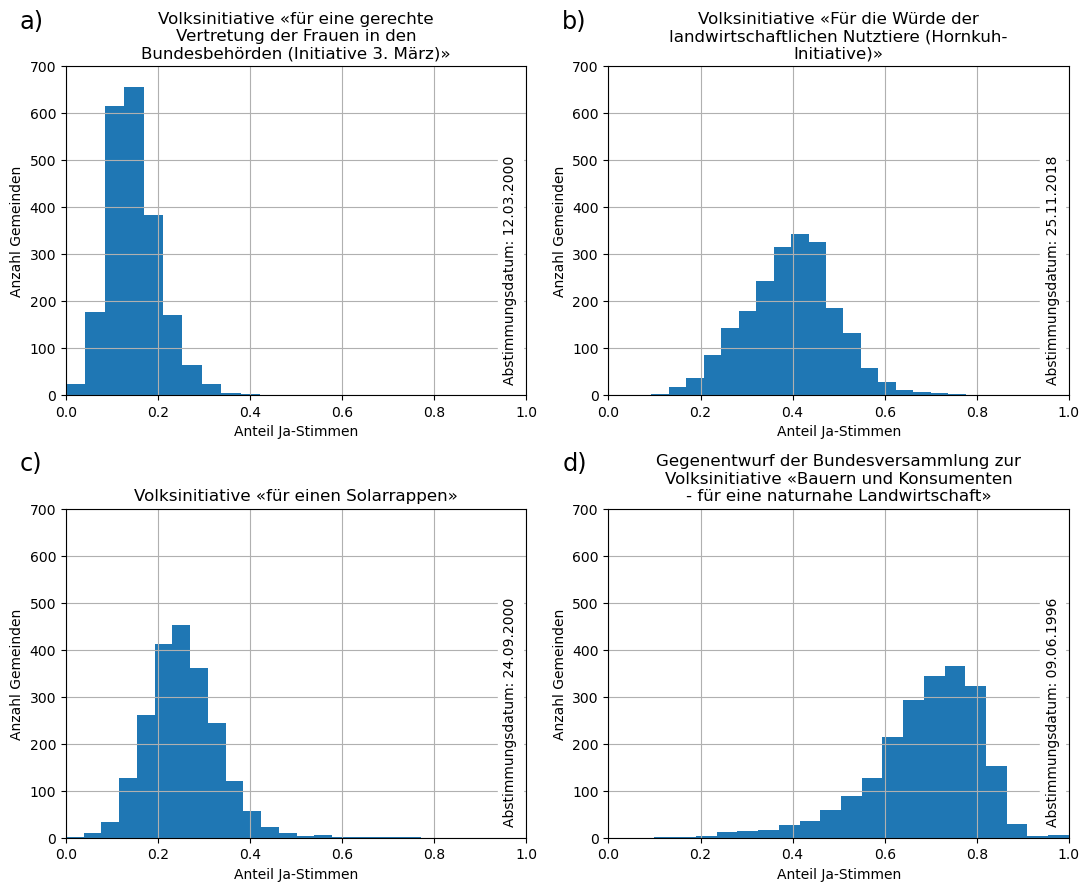

In [20]:
# Zufallszahlengenerator initialisieren für Reproduzierbarkeit
np.random.seed(random_state)
# Zufällige Auswahl von vier Abstimmungen
Abst_Nr = np.random.randint(0, high=308, size=4)

plot_labels = ['a)', 'b)', 'c)', 'd)']

#Plotbereich mit Grösse initialisieren
plt.figure(figsize=[11, 9])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

# Schlaufe um vier Unterplots zu erzeugen
for i in range(0,4) :
    Abst_Nr_i=df_Abstimmungen.loc[Abst_Nr[i]].Abstimmung # Offizielle Abstimmungsnummer extrahieren
    plt.subplot(2, 2, i+1)
    df_Gemeinden[Abst_Nr_i].hist(bins=20)
    plt.title("\n".join(wrap(df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_i].iloc[0, 1][11:], width=40))) # Titel mit maximal 40 Zeichen pro Zeile
    plt.xlabel('Anteil Ja-Stimmen')
    plt.ylabel('Anzahl Gemeinden')
    # Text mit Abstimmungsdatum hinzufügen
    plt.text(0.95, 30, 'Abstimmungsdatum: ' + '.'.join([df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_i].iloc[0, 1][8:10],
                                                        df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_i].iloc[0, 1][5:7],
                                                        df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_i].iloc[0, 1][0:4]]),
             rotation='vertical', backgroundcolor='white')
    plt.xlim(0, 1)
    plt.ylim(0, 700)
    plt.text(-0.1, 770, plot_labels[i], horizontalalignment='left', verticalalignment='bottom', size='xx-large')


save_fig('Gemeinderesultate')
plt.show()

## Clustering mit k-means

In [21]:
# Datenary für Clustering Algorithmus erzeugen
# Enfernen von Variablen, welche nicht verwendet werden
X = np.asarray(df_Gemeinden.dropna().drop(columns=['Einheit', 'Bezeichnung', 'Berechtigte']))
X

array([[0.261, 0.367, 0.353, ..., 0.629, 0.623, 0.483],
       [0.256, 0.306, 0.309, ..., 0.622, 0.57 , 0.476],
       [0.398, 0.528, 0.541, ..., 0.617, 0.554, 0.503],
       ...,
       [0.133, 0.094, 0.108, ..., 0.445, 0.338, 0.351],
       [0.156, 0.144, 0.175, ..., 0.444, 0.342, 0.386],
       [0.16 , 0.133, 0.133, ..., 0.437, 0.354, 0.407]])

### Bewertung der Anzahl Cluster

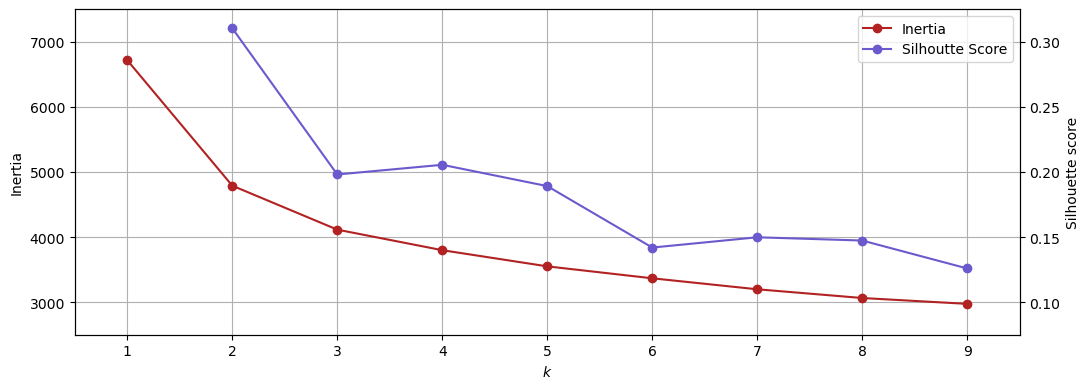

In [22]:
fig, ax1 = plt.subplots(figsize=(11, 4))

# Code Quelle:
# Géron, Aurélien. 2023: Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems.
# Beijing Boston Farnham Sebastopol Tokyo: O’Reilly.
kmeans_per_k = [KMeans(n_clusters=k, random_state=random_state).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(1, 10), inertias, 'o-', color='firebrick', label='Inertia')
plt.xlabel('$k$')
plt.ylabel('Inertia')
plt.xlim(0.5, 9.5)
plt.ylim(2500, 7500)
plt.grid()


# Silhoutte Score vs. k
ax2 = ax1.twinx()

# Code Quelle:
# Géron, Aurélien. 2023: Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems.
# Beijing Boston Farnham Sebastopol Tokyo: O’Reilly.
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
ax2.plot(range(2, 10), silhouette_scores, 'o-', color='slateblue', label='Silhoutte Score')
ax2.set_ylabel('Silhouette score')
ax2.set_ylim(0.075, 0.325)


# Legende hinzufügen
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

save_fig("k-means_Kriterien")
plt.show()

Der Inertia Plot zeigt kein deutlicher Ellenbogen und erlaubt keine gute Aussage bezüglich guter Anzahl an Gruppen.

Aus dem Silhoutte Score Plot wird deutlich, dass sich die einzelnen Gemeinden nur schlecht Gruppieren lassen.

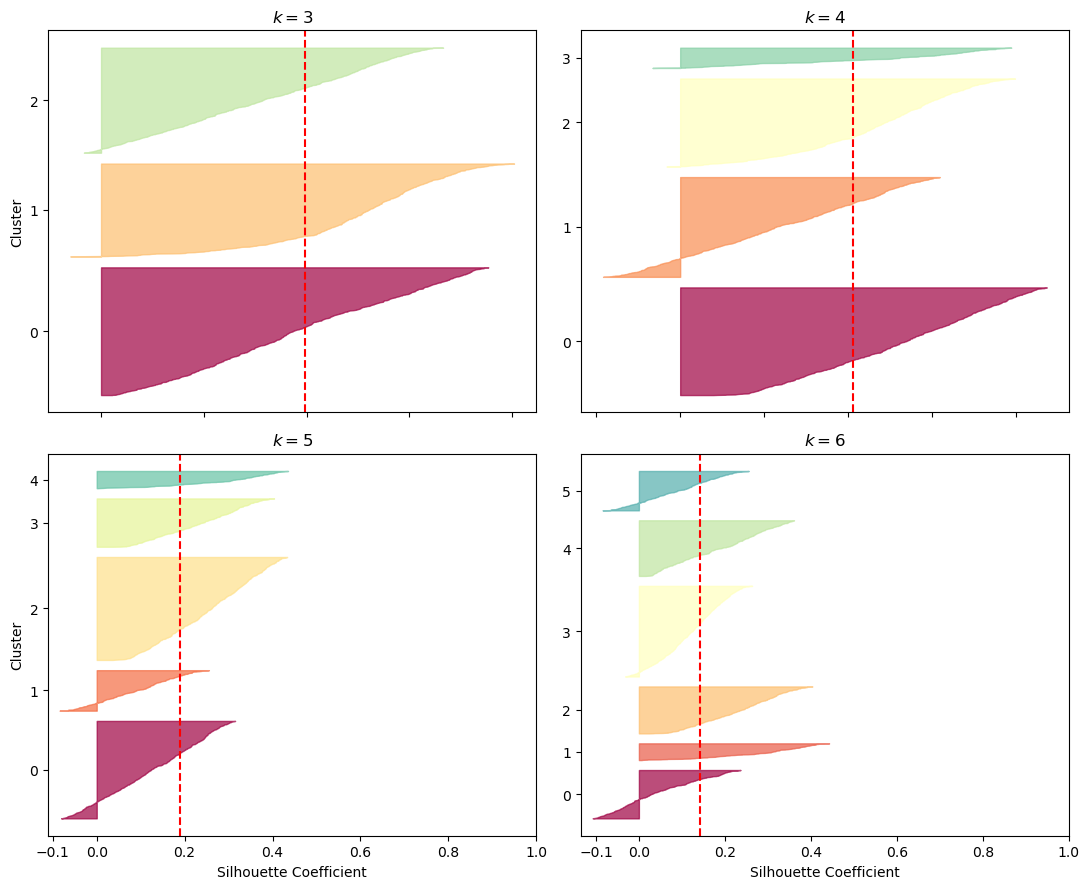

In [23]:
# Code Quelle:
# Géron, Aurélien. 2023: Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems.
# Beijing Boston Farnham Sebastopol Tokyo: O’Reilly.

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

### Clustering

Die Daten, welche für das Maschinelle Lernen im Folgenden verwendet werden, werden mit vier "idealtypischen" Gemeinden ergänzt.

In [24]:
# k-means Algorithmus
k = 4
kmeans = KMeans(n_clusters=k, random_state=random_state)
Gemeinden_pred = kmeans.fit_predict(X)

In [25]:
# Anzahl Geimeinden pro Cluster
pd.DataFrame(y_pred).value_counts().sort_values(ascending=False)

3    646
4    397
0    345
2    335
5    281
1    120
dtype: int64

### Gemeinden, welche am nächsten an den Cluster-Zentren liegen

In [26]:
# Gemeindenummer als abhängige Variable
y = np.asarray(df_Gemeinden.dropna().Einheit)

# k-Neares-Neighbor mit einem einzigen Nachbarn initialiseiren
knn = KNeighborsClassifier(n_neighbors=1)

# kNN-Modell trainieren
knn.fit(X, y)

# Nächster Nachbar zu den Cluster-Zentren bestimmen
Ideal_Gemeinden = knn.predict(kmeans.cluster_centers_)

# Liste der Gemeinden am näcsten zu den Cluster Zentren
#df_Gemeinden_Ideal = df_Gemeinden.loc[df_Gemeinden.Einheit.isin(Ideal_Gemeinden)].loc[:, ['Einheit', 'Bezeichnung', 'Berechtigte']]
df_Gemeinden_Ideal = df_Gemeinden.loc[df_Gemeinden.Einheit.isin(Ideal_Gemeinden)]
df_Gemeinden_Ideal

,Einheit,Bezeichnung,Berechtigte,3590,3600,3610,3620,3630,3640,3650,...,6520,6530,6540,6550,6560,6570,6580,6590,6600,6610
482,0979,Herzogenbuchsee,4871.0,0.278,0.354,0.337,0.384,0.456,0.485,0.436,...,0.563,0.305,0.395,0.547,0.533,0.721,0.351,0.552,0.516,0.412
595,1301,Einsiedeln,10737.0,0.205,0.251,0.235,0.261,0.385,0.384,0.412,...,0.401,0.421,0.337,0.402,0.452,0.661,0.236,0.587,0.579,0.523
1592,5398,Gambarogno,3539.0,0.317,0.300,0.273,0.296,0.508,0.451,0.549,...,0.550,0.394,0.483,0.560,0.642,0.643,0.346,0.484,0.436,0.430
1800,5749,Chavornay,2759.0,0.109,0.109,0.132,0.104,0.629,0.569,0.467,...,0.607,0.351,0.501,0.697,0.801,0.741,0.255,0.427,0.348,0.415


Die vier "idealtypischen" Gemeinden, welche dem Cluster-Schwerpunkt am nächsten kommen, sind über die gesamte Schweiz verteilt und decken die drei grössten Sprachregionen der Schweiz ab. Herzogenbuchse befindet sich im deutschsprachigen Mittelland, Einsiedeln in der Innerschweiz, Gambarogno in italienischsprachigen Tessin und Chavornay in der französischsprachigen Westschweiz.

Die Raumgliederung der vier Gemeinden ist nach der Einteilung des Bundesamtes für Statistik (BFS) die folgende (Quelle: https://www.bfs.admin.ch/bfs/de/home/statistiken/querschnittsthemen/raeumliche-analysen/raeumliche-gliederungen.html):
- Herzogenbuchsee: Industriegemeinde eines ländlichen Zentrums
- Einsiedeln: Städtische Dienstleistungsgemeinde einer kleinen oder ausserhalb einer Agglomeration
- Gambarogno: Periurbane Industriegemeinde geringer Dichte
- Chavornay: Periurbane Industriegemeinde mittlerer Dichte

Auffällig ist, dass keine der vier Gemeinden einen grossstädtischen oder stark löndlichen Charakter aufweist.

### Darstellung Clusterzuordnung zu einigen Abstimmungen

In [27]:
df_Gemeinden_Ideal

,Einheit,Bezeichnung,Berechtigte,3590,3600,3610,3620,3630,3640,3650,...,6520,6530,6540,6550,6560,6570,6580,6590,6600,6610
482,0979,Herzogenbuchsee,4871.0,0.278,0.354,0.337,0.384,0.456,0.485,0.436,...,0.563,0.305,0.395,0.547,0.533,0.721,0.351,0.552,0.516,0.412
595,1301,Einsiedeln,10737.0,0.205,0.251,0.235,0.261,0.385,0.384,0.412,...,0.401,0.421,0.337,0.402,0.452,0.661,0.236,0.587,0.579,0.523
1592,5398,Gambarogno,3539.0,0.317,0.300,0.273,0.296,0.508,0.451,0.549,...,0.550,0.394,0.483,0.560,0.642,0.643,0.346,0.484,0.436,0.430
1800,5749,Chavornay,2759.0,0.109,0.109,0.132,0.104,0.629,0.569,0.467,...,0.607,0.351,0.501,0.697,0.801,0.741,0.255,0.427,0.348,0.415


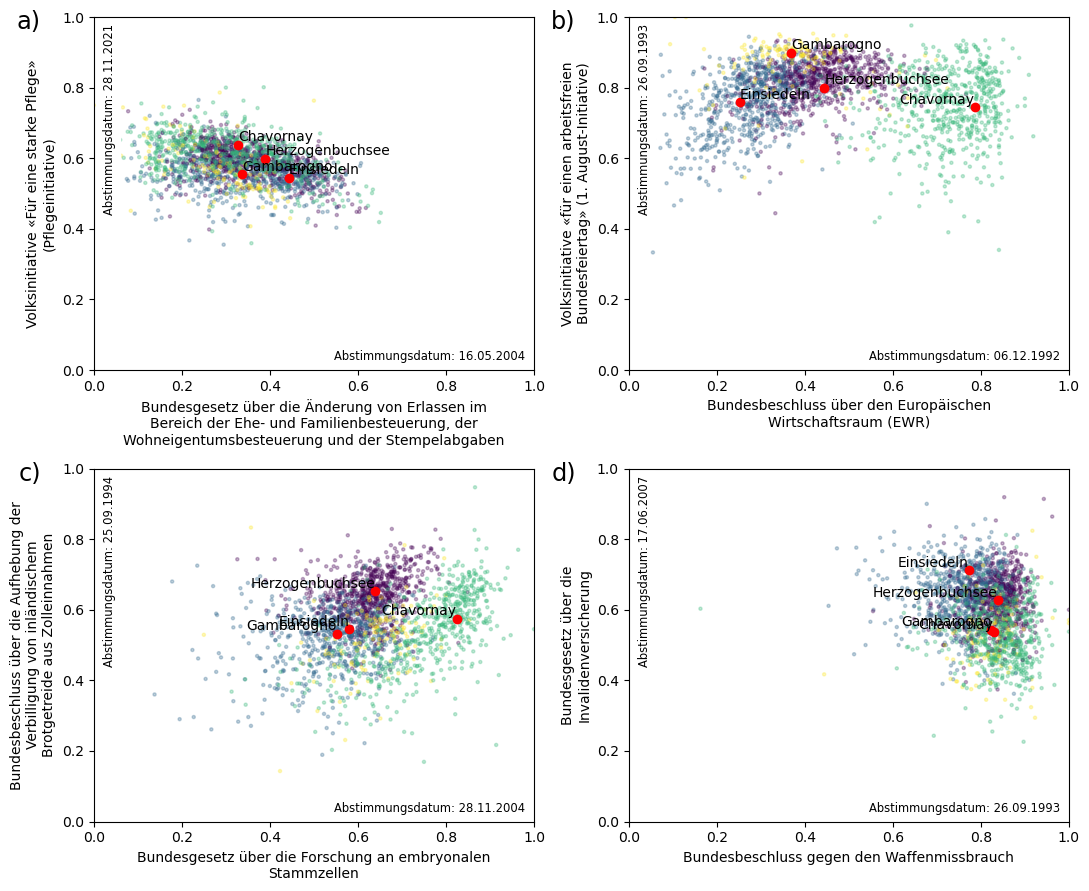

In [28]:
# Zufallszahlengenerator initialisieren für Reproduzierbarkeit
np.random.seed(random_state+13)
# Zufällige Auswahl von vier mal zwei Abstimmungen
Abst_Nr = np.random.randint(0, high=308, size=(4,2))

#Plotbereich mit Grösse initialisieren
fig, axs = plt.subplots(2, 2, figsize=[11, 9])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plot_labels = [['a)', 'b)'], ['c)', 'd)']]

# Schlaufe um vier Unterplots zu erzeugen
for i in range(0,2) :
    for j in range(0,2) :
        Abst_Nr_x = df_Abstimmungen.loc[Abst_Nr[2*i+j,0]].Abstimmung # Offizielle Abstimmungsnummer extrahieren
        Abst_Nr_y = df_Abstimmungen.loc[Abst_Nr[2*i+j,1]].Abstimmung # Offizielle Abstimmungsnummer extrahieren
        axs[i, j].scatter(df_Gemeinden.drop(columns=['Einheit', 'Bezeichnung', 'Berechtigte']).dropna()[Abst_Nr_x],
                          df_Gemeinden.drop(columns=['Einheit', 'Bezeichnung', 'Berechtigte']).dropna()[Abst_Nr_y],
                          c=Gemeinden_pred, alpha=0.3, s=5)
        axs[i, j].axis([0, 1, 0, 1])
        axs[i, j].set_xlabel("\n".join(wrap(df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_x].iloc[0, 1][11:], width=50))) # Titel mit maximal 50 Zeichen pro Zeile
        axs[i, j].set_ylabel("\n".join(wrap(df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_y].iloc[0, 1][11:], width=40))) # Titel mit maximal 40 Zeichen pro Zeile
        axs[i, j].text(0.98, 0.02, 'Abstimmungsdatum: ' + '.'.join([df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_x].iloc[0, 1][8:10],
                                                        df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_x].iloc[0, 1][5:7],
                                                        df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_x].iloc[0, 1][0:4]]),
                       rotation='horizontal', backgroundcolor='white', horizontalalignment='right', verticalalignment='bottom', size='small')
        axs[i, j].text(0.02, 0.98, 'Abstimmungsdatum: ' + '.'.join([df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_y].iloc[0, 1][8:10],
                                                        df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_y].iloc[0, 1][5:7],
                                                        df_Abstimmungen.loc[df_Abstimmungen['Abstimmung'] == Abst_Nr_y].iloc[0, 1][0:4]]),
                       rotation='vertical', backgroundcolor='white', horizontalalignment='left', verticalalignment='top', size='small')
        # Labels der Subplots hinzufügen
        axs[i, j].text(-0.12, 1.02, plot_labels[i][j], horizontalalignment='right', verticalalignment='top', size='xx-large')
        # Resultate der "idealtypischen" Gemeinden hinzufügen
        axs[i, j].scatter(df_Gemeinden_Ideal[Abst_Nr_x], df_Gemeinden_Ideal[Abst_Nr_y], color='red')
        # Label der "idealtypischen" Gemeinden hinzufügen
        for idx, row in df_Gemeinden_Ideal.iterrows():
             axs[i, j].text(row[Abst_Nr_x], row[Abst_Nr_y]+0.01, row['Bezeichnung'], color='black', horizontalalignment='left' if row[Abst_Nr_x] < 0.5 else 'right')

save_fig('Abstimmungen_Gemeinden')
plt.show()

# Daten zu Abstimmungen

## Daten zu Abstimmungen

### Daten einlesen

In [29]:
# Daten einlesen
df_Abstimmungen = pd.read_csv("swiss_votes-DATASET XLSX 31-07-2023 - cleaned.csv", sep=";", na_values=["9999", "."])

# Nicht verwendete Variablen entfernen
df_Abstimmungen = df_Abstimmungen.drop(columns=['titel_off_d', 'd1e2', 'd1e3', 'd2e1', 'd2e2', 'd2e3', 'd3e1', 'd3e2', 'd3e3', 'dep', 'legislatur', 'legisjahr',
                                'bv-pos', 'nr-pos',  'nrnein', 'sr-pos', 'srnein', 'urheber', 'nr-wahl', 'p-ldu', 'p-poch', 'p-rep', 'w-fdp', 'w-sp', 'w-svp', 'w-mitte', 'w-evp', 'w-gps', 'w-glp', 'w-csp', 'w-pda',
                                'w-sd', 'w-edu', 'w-fps', 'w-lega', 'w-kvp', 'w-mcg', 'w-cvp', 'w-bdp', 'w-lps', 'w-ldu', 'w-poch', 'w-rep', 'w-ubrige', 'nein-lager', 'keinepar-summe', 'leer-summe',
                                'freigabe-summe', 'unbekannt-summe', 'neutral-summe', 'volk', 'stand', 'annahme', 'berecht', 'stimmen', 'bet', 'leer', 'ungultig', 'gultig',
                                'volkja', 'volknein', 'kt-nein', 'ktjaproz'])
df_Abstimmungen

,anr,datum,rechtsform,d1e1,br-pos,nrja,srja,p-fdp,p-sps,p-svp,...,p-ldk,p-vdk,p-sodk,p-endk,p-fdk,p-edk,p-bpuk,ja-lager,volkja-proz,kt-ja
0,1.0,12.09.1848,1,1,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.83,15.5
1,2.0,14.01.1866,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.44,9.5
2,3.0,14.01.1866,1,12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.23,12.5
3,4.0,14.01.1866,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.08,8.0
4,5.0,14.01.1866,1,6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.88,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,660.0,25.09.2022,2,10,1.0,125.0,31.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.4,50.55,13.5
679,661.0,25.09.2022,2,6,1.0,125.0,31.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.3,47.99,10.0
680,662.0,18.06.2023,1,6,1.0,127.0,38.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.2,78.45,23.0
681,663.0,18.06.2023,2,9,1.0,139.0,38.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.8,59.07,17.5


In der Zeit seit Einführung des modernen Bundesstaates 1848 bis Juli 2023 könnte die stimmberechtigte Bevölkerung der Schweiz gesamthaft 683 Entscheide fällen. In der hier gemachten Betrachtung sind auch einige Stichfragen enthalten, was die effektive Anzahl Vorlagen reduziert.

In [30]:
# Extraktion der Vorlagen in einer bestimmten Zeitperiode

# Neue Variable mit Jahr der Abstimmung hinzufügen
df_Abstimmungen['jahr'] = df_Abstimmungen.datum.str.slice(start=6).astype(int)

# Abstimmungen für bestimmte Jahre auswählen und Variablen für Datum und Jahr entfernen
df_Abstimmungen=df_Abstimmungen.query('jahr >= 1990').drop(columns=['datum', 'jahr']) # Abstimmungen seit 1990
df_Abstimmungen

,anr,rechtsform,d1e1,br-pos,nrja,srja,p-fdp,p-sps,p-svp,p-mitte,...,p-ldk,p-vdk,p-sodk,p-endk,p-fdk,p-edk,p-bpuk,ja-lager,volkja-proz,kt-ja
371,359.0,3,8,2.0,29.0,0.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.26,28.51,0.0
372,360.0,3,8,2.0,45.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.99,32.72,0.0
373,361.0,3,8,2.0,48.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.99,31.37,0.0
374,362.0,3,8,2.0,49.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.99,34.04,0.0
375,363.0,2,5,1.0,70.0,35.0,1.0,5.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.59,46.66,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,660.0,2,10,1.0,125.0,31.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.40,50.55,13.5
679,661.0,2,6,1.0,125.0,31.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.30,47.99,10.0
680,662.0,1,6,1.0,127.0,38.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.20,78.45,23.0
681,663.0,2,9,1.0,139.0,38.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.80,59.07,17.5


Seit 1990 wurde die Stimmbevölkerung zu 312 Vorlagen befragt.

In [31]:
# Abstimmungs-Nr. mit Zehn multiplizieren für Kompatabilität mit Datensatz des BFS
df_Abstimmungen['anr'] = (df_Abstimmungen['anr']*10).astype(int)
df_Abstimmungen

,anr,rechtsform,d1e1,br-pos,nrja,srja,p-fdp,p-sps,p-svp,p-mitte,...,p-ldk,p-vdk,p-sodk,p-endk,p-fdk,p-edk,p-bpuk,ja-lager,volkja-proz,kt-ja
371,3590,3,8,2.0,29.0,0.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.26,28.51,0.0
372,3600,3,8,2.0,45.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.99,32.72,0.0
373,3610,3,8,2.0,48.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.99,31.37,0.0
374,3620,3,8,2.0,49.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.99,34.04,0.0
375,3630,2,5,1.0,70.0,35.0,1.0,5.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.59,46.66,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,6600,2,10,1.0,125.0,31.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.40,50.55,13.5
679,6610,2,6,1.0,125.0,31.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.30,47.99,10.0
680,6620,1,6,1.0,127.0,38.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.20,78.45,23.0
681,6630,2,9,1.0,139.0,38.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.80,59.07,17.5


In [32]:
# Resultate aus den "idealtypischen" Gemeinden anfügen
# Der Data Frame mit den Resultaten aus den "idealtypischen" Gemeinden muss transponiert, die Spalten umbenannt sowie einige Zeilen entfernt werden, damit die beiden Frames für das Zusammenfügen kompatibel sind.
df_Abstimmungen=df_Abstimmungen.merge(df_Gemeinden_Ideal.transpose().rename(columns=df_Gemeinden_Ideal.transpose().iloc[1].str.replace(' ', '_').str.replace('-', '_').str.replace('â', 'a'))
                                      .reset_index().drop([0, 1, 2]).rename(columns={'index': 'anr'}),
                                      how='inner', on='anr')
df_Abstimmungen

,anr,rechtsform,d1e1,br-pos,nrja,srja,p-fdp,p-sps,p-svp,p-mitte,...,p-fdk,p-edk,p-bpuk,ja-lager,volkja-proz,kt-ja,Herzogenbuchsee,Einsiedeln,Gambarogno,Chavornay
0,3590,3,8,2.0,29.0,0.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,31.26,28.51,0.0,0.278,0.205,0.317,0.109
1,3600,3,8,2.0,45.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,33.99,32.72,0.0,0.354,0.251,0.3,0.109
2,3610,3,8,2.0,48.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,33.99,31.37,0.0,0.337,0.235,0.273,0.132
3,3620,3,8,2.0,49.0,5.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,33.99,34.04,0.0,0.384,0.261,0.296,0.104
4,3630,2,5,1.0,70.0,35.0,1.0,5.0,1.0,NaN,...,NaN,NaN,NaN,37.59,46.66,11.0,0.456,0.385,0.508,0.629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,6570,2,2,1.0,88.0,30.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,65.20,71.48,23.0,0.721,0.661,0.643,0.741
305,6580,3,5,2.0,77.0,8.0,2.0,1.0,2.0,2.0,...,NaN,NaN,NaN,37.90,37.13,0.5,0.351,0.236,0.346,0.255
306,6590,1,10,1.0,126.0,43.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,65.40,55.07,18.0,0.552,0.587,0.484,0.427
307,6600,2,10,1.0,125.0,31.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,65.40,50.55,13.5,0.516,0.579,0.436,0.348


In [33]:
df_Abstimmungen.dtypes

anr                 object
rechtsform           int64
d1e1                 int64
br-pos             float64
nrja               float64
srja               float64
p-fdp              float64
p-sps              float64
p-svp              float64
p-mitte            float64
p-evp              float64
p-gps              float64
p-glp              float64
p-ucsp             float64
p-pda              float64
p-sd               float64
p-edu              float64
p-fps              float64
p-lega             float64
p-kvp              float64
p-mcg              float64
p-cvp              float64
p-bdp              float64
p-lps              float64
p-eco              float64
p-sgv              float64
p-sbv              float64
p-sgb              float64
p-travs            float64
p-sav              float64
p-vsa              float64
p-vpod             float64
p-voev             float64
p-tcs              float64
p-vcs              float64
p-acs              float64
p-sbk              float64
p

### Rechtsform

Rechtsform der Abstimmungsvorlage

1 Obligatorisches Referendum

2 Fakultatives Referendum

3 Volksinitiative

4 Direkter Gegenentwurf zu einer Volksinitiative

5 Stichfrage (seit 1987 bei Gegenüberstellung von Volksinitiativen und Gegenentwürfen)

In [34]:
# Anzahl Abstimmungen nach Rechtsform
df_Abstimmungen[['rechtsform']].value_counts()

rechtsform
3             131
2             107
1              52
4              16
5               3
dtype: int64

In [35]:
# Abstimmungen zu Stichfrage und Variable zur Rechtsform entfernen
df_Abstimmungen = df_Abstimmungen.query('rechtsform != 5').drop(columns='rechtsform').reset_index(drop=True)

### Partei- und Verbandspositionen

1 Ja-Parole
2 Nein-Parole
3 Der Akteur beschloss, keine Parole abzugeben
4 Der Akteur empfahl, einen leeren Stimmzettel einzulegen
5 Der Akteur beschloss Stimmfreigabe
8 Parole auf Bevorzugung des Gegenentwurfs (bei Stichfragen)
9 Parole auf Bevorzugung der Volksinitiative (bei Stichfragen)

In [36]:
# Anzahl vorhandene Parolen pro Partei bzw. Interessengruppe
df_Abstimmungen[df_Abstimmungen.columns[df_Abstimmungen.columns.str.startswith('p-')]].count()

p-fdp      306
p-sps      306
p-svp      306
p-mitte     24
p-evp      306
p-gps      306
p-glp      133
p-ucsp     180
p-pda      298
p-sd       305
p-edu      304
p-fps      272
p-lega     225
p-kvp      138
p-mcg       44
p-cvp      282
p-bdp      104
p-lps      184
p-eco      240
p-sgv      257
p-sbv      205
p-sgb      264
p-travs    245
p-sav      162
p-vsa       95
p-vpod      44
p-voev       9
p-tcs        7
p-vcs       14
p-acs        8
p-sbk       19
p-ssv       34
p-gem       20
p-kdk       22
p-kkjpd      3
p-gdk        2
p-ldk        1
p-vdk        2
p-sodk       2
p-endk       4
p-fdk        8
p-edk        0
p-bpuk       1
dtype: int64

In [37]:
# Variablen mit weniger als 20 Einträgen entfernen
df_Abstimmungen = df_Abstimmungen.drop(columns=df_Abstimmungen.columns[df_Abstimmungen.count() < 20])

In [38]:
# Anzahl Parolen mit Parolenverzicht, Leerparole und Stimmfreigabe
df_Abstimmungen.filter(regex='^p-').where(df_Abstimmungen.filter(regex='^p-')>2, other=np.NaN).count()

p-fdp       1
p-sps      14
p-svp       4
p-mitte     1
p-evp       8
p-gps      13
p-glp       5
p-ucsp      7
p-pda      19
p-sd       21
p-edu       2
p-fps       3
p-lega     39
p-kvp       4
p-mcg       1
p-cvp       1
p-bdp       1
p-lps       1
p-eco      19
p-sgv      19
p-sbv      35
p-sgb      27
p-travs    22
p-sav       8
p-vsa      14
p-vpod      1
p-ssv       4
p-gem       0
p-kdk       0
dtype: int64

Die Anzahl dieser drei Parolentypen sind relativ gering, weshalb diese auf NA gesetzt und imputiert werden. Die Imputation wird hier und nicht in der späteren Pipeline gemacht, weil ein der KNN Imputer verwendet werden soll, und dieser sich ausschliesslich auf die verfügbaren Parolen beziehen soll.

In [39]:
# Parolenverzicht, Leerparole und Stimmfreigabe durch NA ersetzen
df_Abstimmungen[df_Abstimmungen.filter(regex='^p-').columns] = df_Abstimmungen.filter(regex='^p-').where(df_Abstimmungen.filter(regex='^p-')<=2, other=np.NaN)

In [40]:
# Parolen umcodieren: 0: Nein, 1: Ja
df_Abstimmungen[df_Abstimmungen.filter(regex='^p-').columns] = df_Abstimmungen.filter(regex='^p-').where(df_Abstimmungen.filter(regex='^p-') != 2, 0)

In [41]:
# Imputieren auf Basis der ausgegebenen Parolen, mit dem nächsten Nachbarn, damit ein binärer Wert erhalten bleibt
imputer = KNNImputer(n_neighbors=1)
df_Abstimmungen[df_Abstimmungen.filter(regex='^p-').columns] = \
    pd.DataFrame(imputer.fit_transform(df_Abstimmungen[df_Abstimmungen.columns[df_Abstimmungen.columns.str.startswith('p-')]]),columns=df_Abstimmungen.columns[df_Abstimmungen.columns.str.startswith('p-')]).astype(int)

### Positionen der Bundesratsparteien

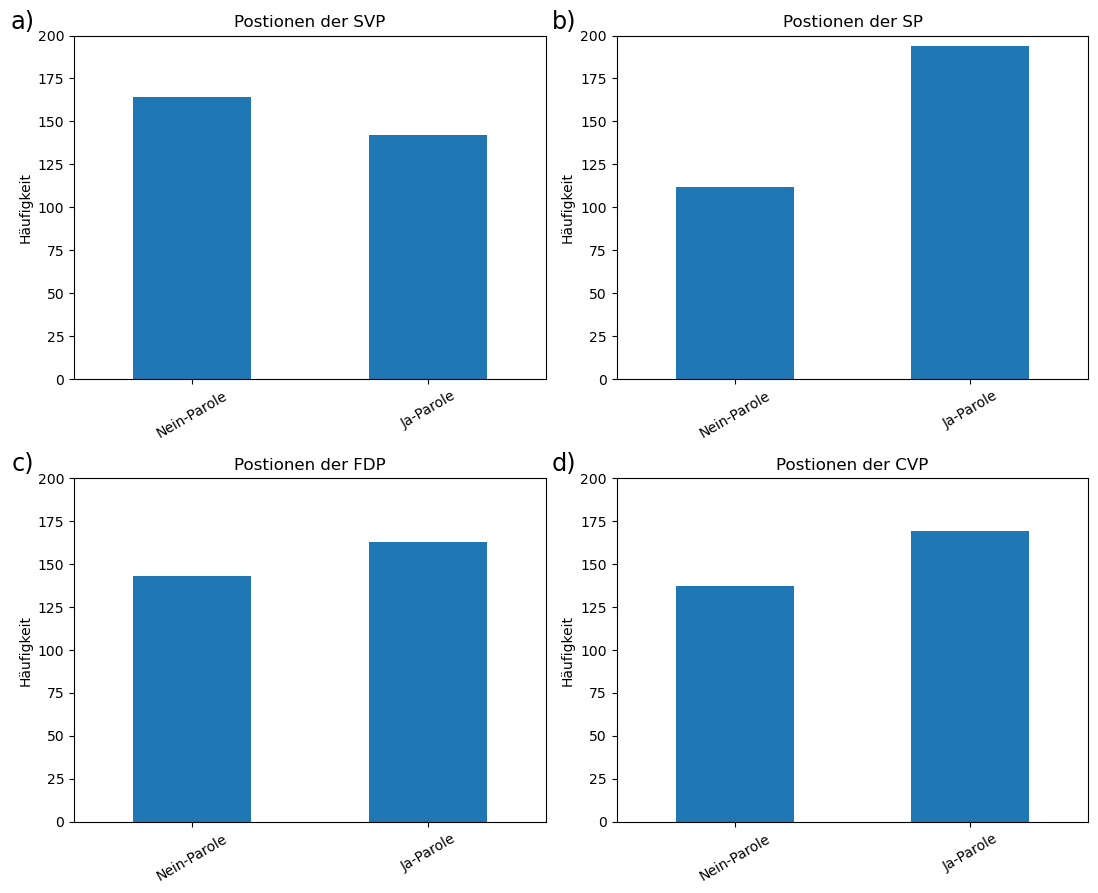

In [42]:
plt.figure(figsize=[11, 9])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)


# Positionen SVP
ax = plt.subplot(2, 2, 1)
df_Abstimmungen.pivot_table(index="p-svp", aggfunc="size").plot(kind="bar", title="Postionen der SVP")
plt.xlabel('') # Leeren String um keine Achsenbeschriftung zu erhalten
plt.ylabel("Häufigkeit")
plt.xticks([0, 1], ["Nein-Parole", "Ja-Parole"], rotation=30,)
plt.ylim(0, 200)
plt.text(-0.67, 215, 'a)', horizontalalignment='right', verticalalignment='top', size='xx-large')

# Positionen SP
ax = plt.subplot(2, 2, 2)
df_Abstimmungen.pivot_table(index="p-sps", aggfunc="size").plot(kind="bar", title="Postionen der SP")
plt.xlabel('') # Leeren String um keine Achsenbeschriftung zu erhalten
plt.ylabel("Häufigkeit")
plt.xticks([0, 1], ["Nein-Parole", "Ja-Parole"], rotation=30,)
plt.ylim(0, 200)
plt.text(-0.67, 215, 'b)', horizontalalignment='right', verticalalignment='top', size='xx-large')

# Positionen FDP
ax = plt.subplot(2, 2, 3)
df_Abstimmungen.pivot_table(index="p-fdp", aggfunc="size").plot(kind="bar", title="Postionen der FDP")
plt.xlabel('') # Leeren String um keine Achsenbeschriftung zu erhalten
plt.ylabel("Häufigkeit")
plt.xticks([0, 1], ["Nein-Parole", "Ja-Parole"], rotation=30,)
plt.ylim(0, 200)
plt.text(-0.67, 215, 'c)', horizontalalignment='right', verticalalignment='top', size='xx-large')

# Positionen Mitte
ax = plt.subplot(2, 2, 4)
df_Abstimmungen.pivot_table(index="p-cvp", aggfunc="size").plot(kind="bar", title="Postionen der CVP")
plt.xlabel('') # Leeren String um keine Achsenbeschriftung zu erhalten
plt.ylabel("Häufigkeit")
plt.xticks([0, 1], ["Nein-Parole", "Ja-Parole"], rotation=30,)
plt.ylim(0, 200)
plt.text(-0.67, 215, 'd)', horizontalalignment='right', verticalalignment='top', size='xx-large')

save_fig('Positionen_Bundesratsparteien')
plt.show()

### Position des Bundesrates

In [43]:
# Auf fehlende Werte überprüfen
df_Abstimmungen['br-pos'].isna().sum()

0

In [44]:
# Parolen umcodieren: 0: Nein, 1: Ja
df_Abstimmungen['br-pos'] = np.where(df_Abstimmungen['br-pos']==1, 1, 0)

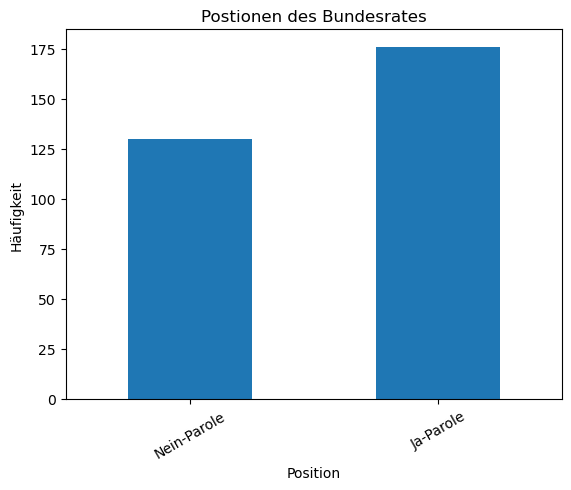

In [45]:
df_Abstimmungen.pivot_table(index="br-pos", aggfunc="size").plot(kind="bar", title="Postionen des Bundesrates")
plt.xlabel("Position")
plt.ylabel("Häufigkeit")
plt.xticks([0, 1], ["Nein-Parole", "Ja-Parole"], rotation=30,)
plt.show()

### Datenübersicht

Entfernen von Abstimmungen zu Stichfrage
Hier existieren nur sehr wenige, weshalb diese aus dem Datensatz entfernt wird
8 Parole auf Bevorzugung des Gegenentwurfs (bei Stichfragen)
9 Parole auf Bevorzugung der Volksinitiative (bei Stichfragen)

## Entscheide im Nationalrat

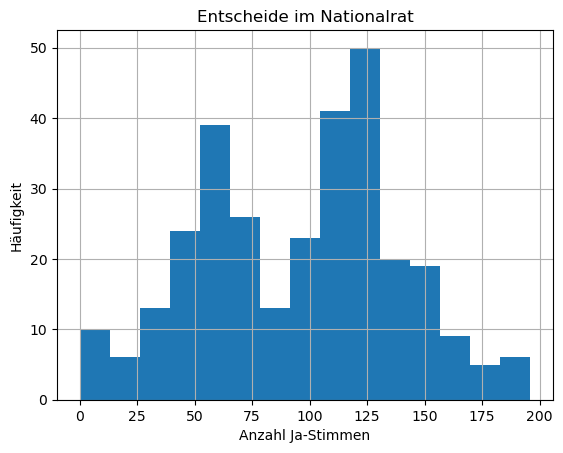

In [46]:
df_Abstimmungen[['nrja']].dropna().hist(bins=15)
plt.title("Entscheide im Nationalrat")
plt.xlabel("Anzahl Ja-Stimmen")
plt.ylabel("Häufigkeit")
plt.show()

Verteilung mit zwei Peaks

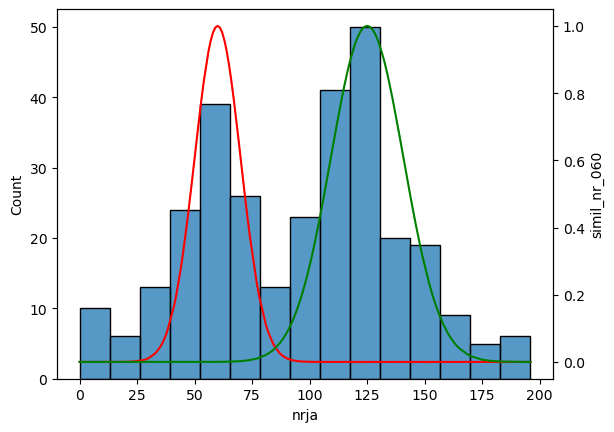

In [47]:
transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[60]], gamma=0.005))
simil_nr_060 = transformer.transform(df_Abstimmungen[['nrja']].dropna())
simil_nr_060 = pd.concat([pd.DataFrame(simil_nr_060, columns=['simil_nr_060']), df_Abstimmungen[['nrja']].dropna().reset_index(drop=True)], axis=1)

transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[125]], gamma=0.002))
simil_nr_125 = transformer.transform(df_Abstimmungen[['nrja']].dropna())
simil_nr_125 = pd.concat([pd.DataFrame(simil_nr_125, columns=['simil_nr_125']), df_Abstimmungen[['nrja']].dropna().reset_index(drop=True)], axis=1)

fig, ax = plt.subplots()
sns.histplot(data=simil_nr_060, x='nrja', ax=ax, bins=15)
ax2 = ax.twinx()
sns.lineplot(data=simil_nr_060, x='nrja', y='simil_nr_060', ax=ax2, color='r')
sns.lineplot(data=simil_nr_125, x='nrja', y='simil_nr_125', ax=ax2, color='g')
plt.show()

## Entscheid im Ständerat

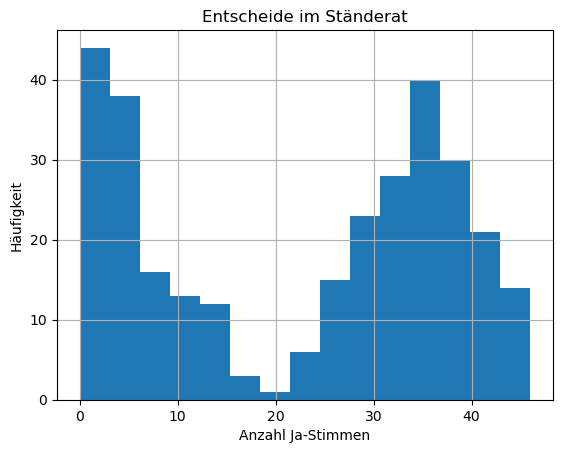

In [48]:
df_Abstimmungen["srja"].hist(bins=15)
plt.title("Entscheide im Ständerat")
plt.xlabel("Anzahl Ja-Stimmen")
plt.ylabel("Häufigkeit")
plt.show()

Verteilung mit zwei Peaks

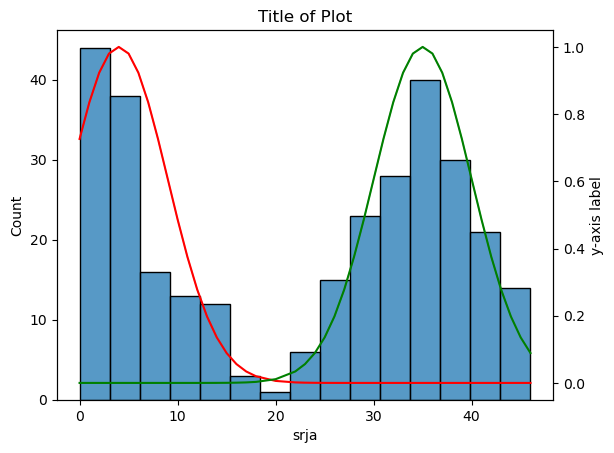

In [49]:
transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[4]], gamma=0.02))
simil_sr_04 = transformer.transform(df_Abstimmungen[['srja']].dropna())
simil_sr_04 = pd.concat([pd.DataFrame(simil_sr_04, columns=['simil_sr_04']), df_Abstimmungen[['srja']].dropna().reset_index(drop=True)], axis=1)

transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.02))
simil_sr_35 = transformer.transform(df_Abstimmungen[['srja']].dropna())
simil_sr_35 = pd.concat([pd.DataFrame(simil_sr_35, columns=['simil_sr_35']), df_Abstimmungen[['srja']].dropna().reset_index(drop=True)], axis=1)

fig, ax = plt.subplots()
sns.histplot(data=simil_sr_04, x='srja', ax=ax, bins=15).set(title='Title of Plot')
ax2 = ax.twinx()
sns.lineplot(data=simil_sr_04, x='srja', y='simil_sr_04', ax=ax2, color='r')
sns.lineplot(data=simil_sr_35, x='srja', y='simil_sr_35', ax=ax2, color='g')
ax2.set(ylabel='y-axis label')

plt.show()

### Ja-Lager im Parlament

Summe der Wähleranteile aller Parteien, welche die Ja Parole ausgaben (Swissvotes (2023): Codebuch für Swissvotes – die Datenbank der eidgenössischen Volksabstimmungen. Année Politique Suisse, Universität Bern. Online: www.swissvotes.ch. Abgerufen am [Datum])

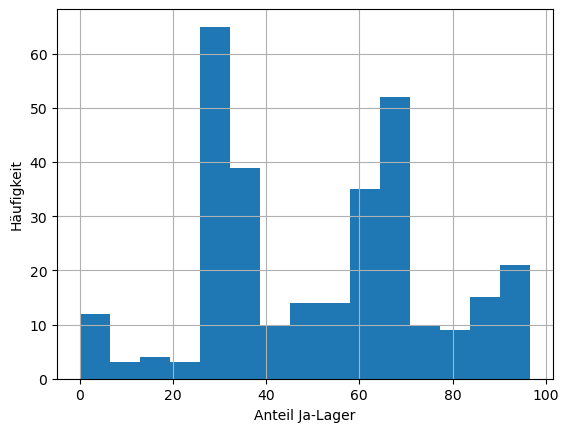

In [50]:
df_Abstimmungen['ja-lager'].hist(bins=15)
plt.xlabel('Anteil Ja-Lager')
plt.ylabel('Häufigkeit')
plt.show()

Unterschied zu Anzahl Ja Stimmen im Nationalrat, mit den beiden zusätzlichen Peaks in den Extremen.

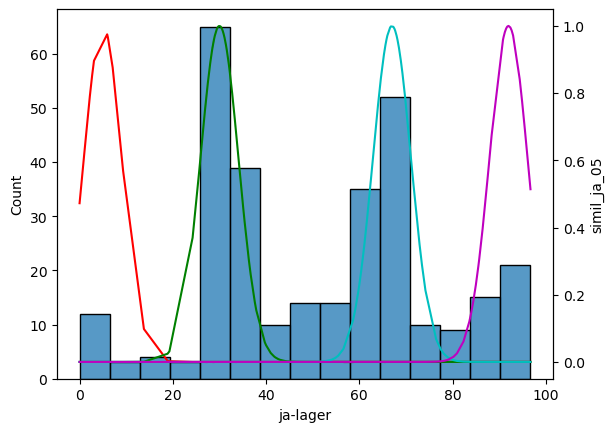

In [51]:
transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[5]], gamma=0.03))
simil_ja_05 = transformer.transform(df_Abstimmungen[['ja-lager']].dropna())
simil_ja_05 = pd.concat([pd.DataFrame(simil_ja_05, columns=['simil_ja_05']), df_Abstimmungen[['ja-lager']].dropna().reset_index(drop=True)], axis=1)

transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[30]], gamma=0.03))
simil_ja_30 = transformer.transform(df_Abstimmungen[['ja-lager']].dropna())
simil_ja_30 = pd.concat([pd.DataFrame(simil_ja_30, columns=['simil_ja_30']), df_Abstimmungen[['ja-lager']].dropna().reset_index(drop=True)], axis=1)

transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[67]], gamma=0.03))
simil_ja_67 = transformer.transform(df_Abstimmungen[['ja-lager']].dropna())
simil_ja_67 = pd.concat([pd.DataFrame(simil_ja_67, columns=['simil_ja_67']), df_Abstimmungen[['ja-lager']].dropna().reset_index(drop=True)], axis=1)

transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[92]], gamma=0.03))
simil_ja_92 = transformer.transform(df_Abstimmungen[['ja-lager']].dropna())
simil_ja_92 = pd.concat([pd.DataFrame(simil_ja_92, columns=['simil_ja_92']), df_Abstimmungen[['ja-lager']].dropna().reset_index(drop=True)], axis=1)

fig, ax = plt.subplots()
sns.histplot(data=simil_ja_05, x='ja-lager', ax=ax, bins=15)
ax2 = ax.twinx()
sns.lineplot(data=simil_ja_05, x='ja-lager', y='simil_ja_05', ax=ax2, color='r')
sns.lineplot(data=simil_ja_30, x='ja-lager', y='simil_ja_30', ax=ax2, color='g')
sns.lineplot(data=simil_ja_67, x='ja-lager', y='simil_ja_67', ax=ax2, color='c')
sns.lineplot(data=simil_ja_92, x='ja-lager', y='simil_ja_92', ax=ax2, color='m')
plt.show()

### Parlamentskammern

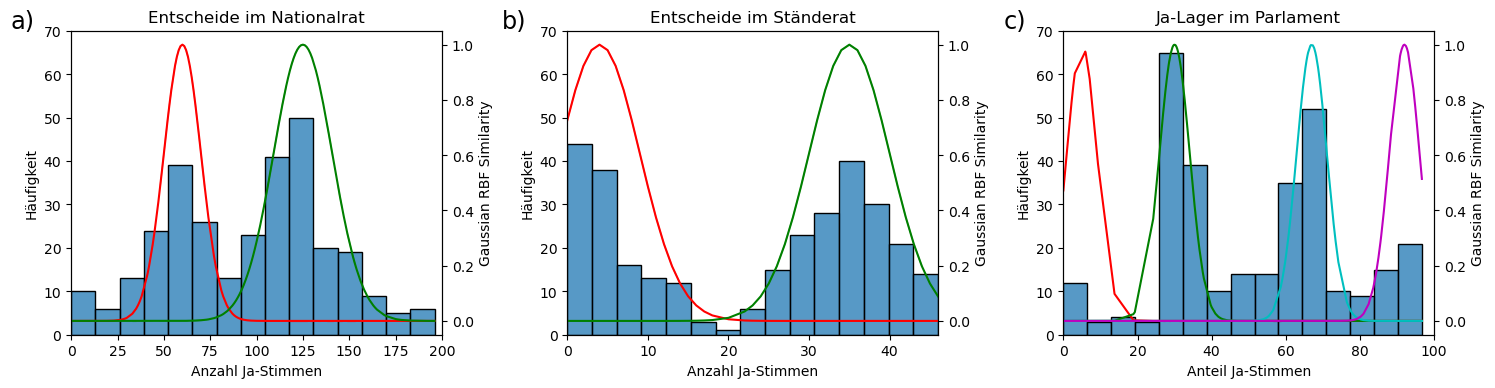

In [52]:
fig, axs = plt.subplots(1, 3, figsize=[15, 4])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# Entscheide im Nationalrat
ax=axs[0]
sns.histplot(data=simil_nr_060, x='nrja', ax=ax, bins=15).set(title='Entscheide im Nationalrat')
ax2 = ax.twinx()
sns.lineplot(data=simil_nr_060, x='nrja', y='simil_nr_060', ax=ax2, color='r')
sns.lineplot(data=simil_nr_125, x='nrja', y='simil_nr_125', ax=ax2, color='g')
ax.set(xlabel='Anzahl Ja-Stimmen', ylabel='Häufigkeit')
ax.text(-20, 75, 'a)', horizontalalignment='right', verticalalignment='top', size='xx-large')
ax.set_xlim(left=0, right=200)
ax.set_ylim(bottom=0, top=70);
ax2.set(ylabel='Gaussian RBF Similarity')

# Entscheide im Ständerat
ax=axs[1]
sns.histplot(data=simil_sr_04, x='srja', ax=ax, bins=15).set(title='Entscheide im Ständerat')
ax2 = ax.twinx()
sns.lineplot(data=simil_sr_04, x='srja', y='simil_sr_04', ax=ax2, color='r')
sns.lineplot(data=simil_sr_35, x='srja', y='simil_sr_35', ax=ax2, color='g')
ax.set(xlabel='Anzahl Ja-Stimmen', ylabel='Häufigkeit')
ax.text(-5, 75, 'b)', horizontalalignment='right', verticalalignment='top', size='xx-large')
ax.set_xlim(left=0, right=46)
ax.set_ylim(bottom=0, top=70);
ax2.set(ylabel='Gaussian RBF Similarity')

# Ja-Lager im Parlament
ax=axs[2]
sns.histplot(data=simil_ja_05, x='ja-lager', ax=ax, bins=15).set(title='Ja-Lager im Parlament')
ax2 = ax.twinx()
sns.lineplot(data=simil_ja_05, x='ja-lager', y='simil_ja_05', ax=ax2, color='r')
sns.lineplot(data=simil_ja_30, x='ja-lager', y='simil_ja_30', ax=ax2, color='g')
sns.lineplot(data=simil_ja_67, x='ja-lager', y='simil_ja_67', ax=ax2, color='c')
sns.lineplot(data=simil_ja_92, x='ja-lager', y='simil_ja_92', ax=ax2, color='m')
ax.set(xlabel='Anteil Ja-Stimmen', ylabel='Häufigkeit')
ax.text(-10, 75, 'c)', horizontalalignment='right', verticalalignment='top', size='xx-large')
ax.set_xlim(left=0, right=100)
ax.set_ylim(bottom=0, top=70);
ax2.set(ylabel='Gaussian RBF Similarity')

save_fig('Resultate_Parlament')
plt.show()

### Resultate in den "idealtypischen" Gemeinden

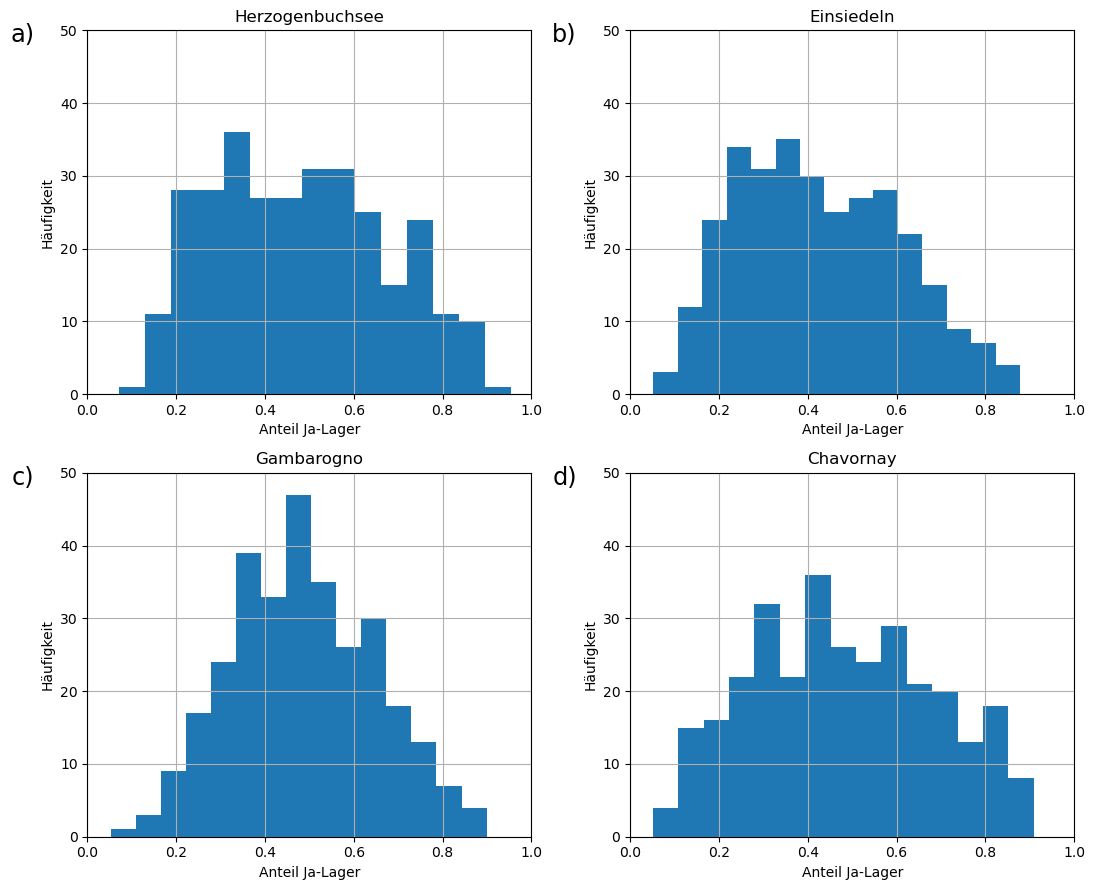

In [53]:
#Plotbereich mit Grösse initialisieren
plt.figure(figsize=[11, 9])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plot_labels = ['a)', 'b)', 'c)', 'd)']

# Schlaufe um vier Unterplots zu erzeugen
for i in range(0,4) :
    Gemeinde = df_Gemeinden_Ideal.reset_index().at[i,'Bezeichnung']
    plt.subplot(2, 2, i+1)
    df_Abstimmungen[Gemeinde].hist(bins=15)
    plt.title(Gemeinde)
    plt.xlabel('Anteil Ja-Lager')
    plt.xlim(0, 1)
    plt.ylabel('Häufigkeit')
    plt.ylim(0, 50)
    plt.text(-0.12, 51, plot_labels[i], horizontalalignment='right', verticalalignment='top', size='xx-large')


save_fig('Resultate_idealtypische_Gemeinden')
plt.show()

Die Verteilung der Ja-Stimmen-Anteile kommt in allen "idealtypischen" Gemeinden einer Normalverteilung nahe. Es wird keine spezielle Skallierung vorgenommen.

### Abstimmungsresultate

In [54]:
# neue Variable mit binärem Resultat Resultat der Volksstimmen
df_Abstimmungen['volkja'] = np.where(df_Abstimmungen['volkja-proz'] >= 50, 1, 0)

In [55]:
#list(df_abst)
#df_abst.dtypes
df_Abstimmungen.describe()
df_Abstimmungen

,anr,d1e1,br-pos,nrja,srja,p-fdp,p-sps,p-svp,p-mitte,p-evp,...,p-gem,p-kdk,ja-lager,volkja-proz,kt-ja,Herzogenbuchsee,Einsiedeln,Gambarogno,Chavornay,volkja
0,3590,8,0,29.0,0.0,0,1,0,0,0,...,0,0,31.26,28.51,0.0,0.278,0.205,0.317,0.109,0
1,3600,8,0,45.0,5.0,0,1,0,0,1,...,0,0,33.99,32.72,0.0,0.354,0.251,0.3,0.109,0
2,3610,8,0,48.0,5.0,0,1,0,0,1,...,0,0,33.99,31.37,0.0,0.337,0.235,0.273,0.132,0
3,3620,8,0,49.0,5.0,0,1,0,0,1,...,0,0,33.99,34.04,0.0,0.384,0.261,0.296,0.104,0
4,3630,5,1,70.0,35.0,1,0,1,1,0,...,1,1,37.59,46.66,11.0,0.456,0.385,0.508,0.629,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,6570,2,1,88.0,30.0,1,0,1,1,1,...,1,1,65.20,71.48,23.0,0.721,0.661,0.643,0.741,1
302,6580,5,0,77.0,8.0,0,1,0,0,0,...,0,0,37.90,37.13,0.5,0.351,0.236,0.346,0.255,0
303,6590,10,1,126.0,43.0,1,0,1,1,1,...,1,1,65.40,55.07,18.0,0.552,0.587,0.484,0.427,1
304,6600,10,1,125.0,31.0,1,0,1,1,1,...,1,1,65.40,50.55,13.5,0.516,0.579,0.436,0.348,1


# Machine Learning Modelle

In [56]:
# Pipelines für Entscheide im Nationalrat
nr1_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("nr1", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[60]], gamma=0.005), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

nr2_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("nr2", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[125]], gamma=0.003), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

# Pipeline für Entscheide im Ständerat
sr1_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("sr1", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[4]], gamma=0.02), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

sr2_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("sr2", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.02), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

# Pipelines für Ja-Lager im Parlament
parl1_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("parl1", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[5]], gamma=0.03), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

parl2_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("parl2", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[30]], gamma=0.03), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

parl3_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("parl3", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[67]], gamma=0.03), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

parl4_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("parl4", FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[92]], gamma=0.03), feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

# Pipeline für Politikbereich
one_hot_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("one_hot_enc", OneHotEncoder(handle_unknown="ignore"))
])

# Default Pipeline
default_num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")), 
    ("scale", StandardScaler()) 
])

preprocessing = ColumnTransformer([
    ('simil060', nr1_pipeline, ['nrja']),
    ('simil125', nr2_pipeline, ['nrja']),
    ('simil004', sr1_pipeline, ['srja']),
    ('simil035', sr2_pipeline, ['srja']),
    ('simil005', parl1_pipeline, ['ja-lager']),
    ('simil030', parl2_pipeline, ['ja-lager']),
    ('simil067', parl3_pipeline, ['ja-lager']),
    ('simil092', parl4_pipeline, ['ja-lager']),
    ('ohe', one_hot_pipeline, ['d1e1']),
    ('default', default_num_pipeline, ['Herzogenbuchsee', 'Einsiedeln', 'Gambarogno', 'Chavornay'])
], remainder="passthrough")

preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('simil060',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('nr1',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x000002D1F32EA9D0>,
                                                                      kw_args={'Y': [[60]],
                                                                               'gamma': 0.005})),
                                                 ('scale', StandardScaler())]),
                                 ['nrja']),
                                ('simil125',
                                 Pipeline(steps=[('impute',
                                                  Simp...
                                                                               'gamma': 0.03})),
                                                 ('scale', StandardScaler())]),
                                 ['ja-lager']),
                                ('ohe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot_enc',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['d1e1']),
                                ('default',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['Herzogenbuchsee', 'Einsiedeln', 'Gambarogno',
                                  'Chavornay'])])

In [57]:
train_set, test_set = train_test_split(df_Abstimmungen.drop(columns=['anr', 'kt-ja']), test_size=0.15, random_state=random_state)
print("Grösse Trainingsdaten:", len(train_set))
print("Grösse Testdaten:", len(test_set))

Grösse Trainingsdaten: 260
Grösse Testdaten: 46


In [58]:
train_set = preprocessing.fit_transform(train_set)
preprocessing.get_feature_names_out()

array(['simil060__nrja', 'simil125__nrja', 'simil004__srja',
       'simil035__srja', 'simil005__ja-lager', 'simil030__ja-lager',
       'simil067__ja-lager', 'simil092__ja-lager', 'ohe__d1e1_1',
       'ohe__d1e1_2', 'ohe__d1e1_3', 'ohe__d1e1_4', 'ohe__d1e1_5',
       'ohe__d1e1_6', 'ohe__d1e1_7', 'ohe__d1e1_8', 'ohe__d1e1_9',
       'ohe__d1e1_10', 'ohe__d1e1_11', 'ohe__d1e1_12',
       'default__Herzogenbuchsee', 'default__Einsiedeln',
       'default__Gambarogno', 'default__Chavornay', 'remainder__br-pos',
       'remainder__p-fdp', 'remainder__p-sps', 'remainder__p-svp',
       'remainder__p-mitte', 'remainder__p-evp', 'remainder__p-gps',
       'remainder__p-glp', 'remainder__p-ucsp', 'remainder__p-pda',
       'remainder__p-sd', 'remainder__p-edu', 'remainder__p-fps',
       'remainder__p-lega', 'remainder__p-kvp', 'remainder__p-mcg',
       'remainder__p-cvp', 'remainder__p-bdp', 'remainder__p-lps',
       'remainder__p-eco', 'remainder__p-sgv', 'remainder__p-sbv',
       'rema

In [59]:
train_set = pd.DataFrame(train_set, columns=preprocessing.get_feature_names_out())
train_set

,simil060__nrja,simil125__nrja,simil004__srja,simil035__srja,simil005__ja-lager,simil030__ja-lager,simil067__ja-lager,simil092__ja-lager,ohe__d1e1_1,ohe__d1e1_2,...,remainder__p-sgb,remainder__p-travs,remainder__p-sav,remainder__p-vsa,remainder__p-vpod,remainder__p-ssv,remainder__p-gem,remainder__p-kdk,remainder__volkja-proz,remainder__volkja
0,-0.592603,1.607052,-0.725172,1.508914,-0.234283,-0.696678,1.193902,-0.339206,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,51.65,1.0
1,-0.592490,0.010777,-0.725172,1.508914,-0.234283,-0.696678,0.528973,-0.339206,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,49.18,0.0
2,-0.592603,-0.795330,1.120970,-0.972397,2.674348,-0.696678,-0.616810,-0.339206,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.86,0.0
3,2.181967,-0.795326,-0.018297,-0.972333,-0.234283,1.763730,-0.616810,-0.339206,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,27.46,0.0
4,-0.518664,-0.795330,1.766860,-0.972397,-0.234283,1.823494,-0.616810,-0.339206,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,-0.592603,1.873021,-0.725172,1.364414,-0.234283,-0.696678,0.870427,-0.339206,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,64.99,1.0
256,-0.592603,-0.760159,-0.725172,0.259785,-0.234283,-0.696678,-0.616810,3.730024,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,77.59,1.0
257,2.113463,-0.795304,0.512334,-0.972388,-0.234283,1.396376,-0.616810,-0.339206,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,31.82,0.0
258,-0.391614,-0.795330,1.766860,-0.972397,-0.234283,1.717665,-0.616810,-0.339206,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,36.34,0.0


In [60]:
test_set = preprocessing.transform(test_set)
test_set = pd.DataFrame(test_set, columns=preprocessing.get_feature_names_out())
test_set

,simil060__nrja,simil125__nrja,simil004__srja,simil035__srja,simil005__ja-lager,simil030__ja-lager,simil067__ja-lager,simil092__ja-lager,ohe__d1e1_1,ohe__d1e1_2,...,remainder__p-sgb,remainder__p-travs,remainder__p-sav,remainder__p-vsa,remainder__p-vpod,remainder__p-ssv,remainder__p-gem,remainder__p-kdk,remainder__volkja-proz,remainder__volkja
0,-0.592602,1.066316,-0.725172,-0.022321,-0.234283,-0.696678,1.577177,-0.339206,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,68.08,1.0
1,-0.592603,-0.319902,-0.725172,1.142037,-0.234283,-0.696678,2.034403,-0.339206,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,48.37,0.0
2,1.622936,-0.795219,1.766860,-0.972397,-0.234283,1.653286,-0.616810,-0.339206,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,39.47,0.0
3,-0.588262,-0.580636,-0.723311,-0.830296,-0.234283,-0.690203,-0.616809,-0.339206,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,43.92,0.0
4,-0.592597,0.691224,-0.725172,0.865803,-0.234283,-0.696678,0.008328,-0.339206,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,36.53,0.0
5,-0.592603,1.187372,-0.725172,1.508914,-0.234283,-0.696678,-0.045276,-0.339206,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,52.80,1.0
6,-0.592586,0.446344,-0.725172,1.142037,-0.234283,-0.696678,0.971301,-0.339206,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,50.99,1.0
7,-0.592603,1.873021,-0.725172,1.142037,-0.234283,-0.696678,1.690110,-0.339206,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,64.37,1.0
8,-0.592531,0.110830,-0.725172,1.364414,-0.234283,-0.696678,1.201938,-0.339206,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,67.97,1.0
9,0.623310,-0.795330,1.120970,-0.972397,-0.234283,1.583287,-0.616810,-0.339206,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,44.71,0.0


## Regressionsmodelle inkl. "idealtypische" Gemeinden (eigene Version)

In [61]:
# Arrays mit unabhängigen und abhängigen Variablen für Regressionsmodelle erstellen
# Arrays mit Trainingsdaten
X_train_reg = np.asarray(train_set.drop(columns=['remainder__volkja-proz', 'remainder__volkja']))
y_train_reg = np.asarray(train_set['remainder__volkja-proz'])

# Arrays mit Testdaten
X_test_reg = np.asarray(test_set.drop(columns=['remainder__volkja-proz', 'remainder__volkja']))
y_test_reg = np.asarray(test_set['remainder__volkja-proz'])

In [62]:
# Standardabweichungen der abhängigen Variablen
print("Trainingsdaten: ", np.std(y_train_reg).round(3))
print("Testdaten     : ", np.std(y_test_reg).round(3))

Trainingsdaten:  17.645
Testdaten     :  16.086


### SGD Regressor

In [63]:
sgd_reg = SGDRegressor(max_iter=10000, tol=0.00001, penalty="elasticnet", eta0=0.01, n_iter_no_change=100, random_state=random_state)
sgd_reg.fit(X_train_reg, y_train_reg)

SGDRegressor(max_iter=10000, n_iter_no_change=100, penalty='elasticnet',
             random_state=42, tol=1e-05)

In [64]:
# RMSE für das Training und das Test Set aus dem initialen Modell
print("RMSE (Training):", mean_squared_error(y_train_reg, sgd_reg.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, sgd_reg.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 1.9225
RMSE (Test)    : 2.0997


In [65]:
# Hyperparameter Tuning mittels Grid Search
param = {
    "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "alpha" : [0.00001, 0.00005, 0.0001, 0.0005]
}
sgd_reg_optim = GridSearchCV(sgd_reg, param, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
sgd_reg_optim.fit(X_train_reg, y_train_reg)

GridSearchCV(cv=10,
             estimator=SGDRegressor(max_iter=10000, n_iter_no_change=100,
                                    penalty='elasticnet', random_state=42,
                                    tol=1e-05),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9]},
             scoring='neg_root_mean_squared_error')

In [66]:
# mittlere und totale Berechnungszeit
print("Mittlere Berechnungszeit pro Fit: ", sgd_reg_optim.cv_results_["mean_fit_time"].mean().round(3),"s", sep="")
print("Gesamte Berechnungszeit für alle Fits: ", sgd_reg_optim.cv_results_["mean_fit_time"].sum().round(1), "s", sep="")

Mittlere Berechnungszeit pro Fit: 0.264s
Gesamte Berechnungszeit für alle Fits: 9.5s


In [67]:
print('Best Score: %s' % -sgd_reg_optim.best_score_.round(4))
print('Best Hyperparameters: %s' % sgd_reg_optim.best_params_)

Best Score: 2.4224
Best Hyperparameters: {'alpha': 0.0005, 'l1_ratio': 0.5}


In [68]:
# SGD Modell mit optimierten Hyperparameter, ohne vorgängige Berechnung der Optimierung
sgd_reg_optim = SGDRegressor(l1_ratio=0.5, alpha=0.0005, max_iter=10000, tol=0.00001, penalty="elasticnet", eta0=0.01, n_iter_no_change=100, random_state=random_state)
sgd_reg_optim.fit(X_train_reg, y_train_reg)

SGDRegressor(alpha=0.0005, l1_ratio=0.5, max_iter=10000, n_iter_no_change=100,
             penalty='elasticnet', random_state=42, tol=1e-05)

In [69]:
# RMSE für das Training und das Test Set aus dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg, sgd_reg_optim.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, sgd_reg_optim.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 1.9226
RMSE (Test)    : 2.0921


Die Bwerteungen haben sich nicht wesentlich verbessert und liegen noch immer sehr nahe beieinander, was auf einen guten Balance zwischen Bias und Variance schliessen lässt.

In [70]:
# Fill data frame with results of final models
df_RMSEs = pd.DataFrame(data=[[mean_squared_error(y_train_reg, sgd_reg_optim.predict(X_train_reg), squared=False), mean_squared_error(y_test_reg, sgd_reg_optim.predict(X_test_reg),squared=False)]],
                        index=["SGD"], columns=["Training", "Test"])

### k-Nearest Neighbors Regressor

In [71]:
knn_reg = KNeighborsRegressor(n_neighbors=10)
knn_reg.fit(X_train_reg, y_train_reg)

KNeighborsRegressor(n_neighbors=10)

In [72]:
print("RMSE (Training):", mean_squared_error(y_train_reg, knn_reg.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, knn_reg.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 5.2709
RMSE (Test)    : 5.9505


In [73]:
param = {
    "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
}
knn_reg_optim = GridSearchCV(knn_reg, param, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
knn_reg_optim.fit(X_train_reg, y_train_reg)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(n_neighbors=10), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]},
             scoring='neg_root_mean_squared_error')

In [74]:
print('Best Score: %s' % -knn_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % knn_reg_optim.best_params_)

Best Score: 5.868
Best Hyperparameters: {'n_neighbors': 5}


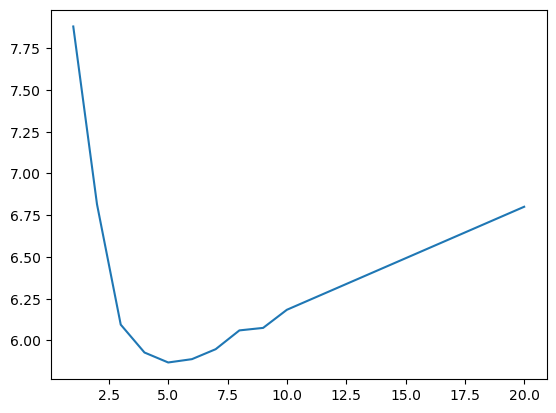

In [75]:
plt.plot(param["n_neighbors"], -knn_reg_optim.cv_results_["mean_test_score"])
plt.show()

In [76]:
# RMSE für das Training und das Test Set aus dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg, knn_reg_optim.predict(X_train_reg), squared= False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, knn_reg_optim.predict(X_test_reg), squared= False).round(4))

RMSE (Training): 4.7434
RMSE (Test)    : 5.7153


Im Vergelich zum SGD Regressor sind die Werte viel höher. Der kNN-Algorithmus ist für diese Anwendung nicht geeignet.

In [77]:
# Fill data frame with results of final models
df_RMSEs = pd.concat([df_RMSEs, pd.DataFrame(data=[[mean_squared_error(y_train_reg, knn_reg_optim.predict(X_train_reg), squared= False),
                                                    mean_squared_error(y_test_reg, knn_reg_optim.predict(X_test_reg), squared= False)]],
                                             index=["kNN"], columns=["Training", "Test"])])

### Support Vector Machines Regressor

Damit die benötigte Rechenzeit nicht zu gross wird, wird hier für die Toleranz ein relativ grosser Wert gesetzt.

In [78]:
svr_rbf_reg = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1, tol=1)
svr_rbf_reg.fit(X_train_reg, y_train_reg)

SVR(C=100, gamma=0.1, tol=1)

In [79]:
# RMSE für Training und Test Set auf dem Initalien Modell
print("RMSE (Training):", mean_squared_error(y_train_reg, svr_rbf_reg.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, svr_rbf_reg.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 0.274
RMSE (Test)    : 3.417


Zwischen den RMSE Werte des Trainings- bzw. des Test-Sets besteht ein grosser Unterschied. Mit den gewählten Hyperparametern ist das Modell schlecht angepasst.

In [80]:
# Anzahl Iterationen bis Modell konvergiert ist
svr_rbf_reg.n_iter_

240

In [81]:
# Einlfuss der Toleranz auf den RMSE testen mittels Grid Search
# Um die Berechnungszeit zu reduzieren wird mit nur 5 Flolds gearbeitet
param = {
    "tol": [0.1, 0.5, 1, 5, 10]
}

svr_rbf_reg_test = GridSearchCV(svr_rbf_reg, param, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, verbose=10)
svr_rbf_reg_test.fit(X_train_reg, y_train_reg)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=SVR(C=100, gamma=0.1, tol=1), n_jobs=-1,
             param_grid={'tol': [0.1, 0.5, 1, 5, 10]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [82]:
space = {
    "C": loguniform(1, 1000),
    "gamma": loguniform(0.01, 1),
    "epsilon": loguniform(0.05, 1)
}
svr_rbf_reg_optim = RandomizedSearchCV(svr_rbf_reg, space, n_iter=50, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, random_state=random_state, verbose=10)
svr_rbf_reg_optim.fit(X_train_reg, y_train_reg)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVR(C=100, gamma=0.1, tol=1), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D184D51A60>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D184D73BE0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D185495E50>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [83]:
# mittlere und totale Berechnungszeit
print("Mittlere Berechnungszeit pro Fit: ", svr_rbf_reg_optim.cv_results_["mean_fit_time"].mean().round(3),"s", sep="")
print("Gesamte Berechnungszeit für alle Fits: ", svr_rbf_reg_optim.cv_results_["mean_fit_time"].sum().round(1), "s", sep="")

Mittlere Berechnungszeit pro Fit: 0.005s
Gesamte Berechnungszeit für alle Fits: 0.2s


In [84]:
print('Best Score: %s' % -svr_rbf_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % svr_rbf_reg_optim.best_params_)

Best Score: 2.574
Best Hyperparameters: {'C': 36.99972431463807, 'epsilon': 0.17997562632086156, 'gamma': 0.011241862095793058}


In [85]:
# SVR Modell mit optimierten Hyperparameter, ohne vorgängige Berechnung der Optimierung
svr_rbf_reg_optim = SVR(kernel="rbf", C=36.9997, gamma=0.01124, epsilon=0.17997, tol=0.1)
svr_rbf_reg_optim.fit(X_train_reg, y_train_reg)

SVR(C=36.9997, epsilon=0.17997, gamma=0.01124, tol=0.1)

In [86]:
# RMSE für Training und Test Set auf dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg, svr_rbf_reg_optim.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test):    ", mean_squared_error(y_test_reg, svr_rbf_reg_optim.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 1.5592
RMSE (Test):     1.9552


Die Optimeirung der Hyperparameter hat zu einer beachtlichen Verbesserung des Modells geführt. Die Differenz der RMSE von Training- bzw. Test-Set ist ebenfalls viel kleiner als im ursprünglichen Modell.

In [87]:
# Fill data frame with results of final models
df_RMSEs = pd.concat([df_RMSEs, pd.DataFrame(data=[[mean_squared_error(y_train_reg, svr_rbf_reg_optim.predict(X_train_reg), squared= False),
                                                    mean_squared_error(y_test_reg, svr_rbf_reg_optim.predict(X_test_reg), squared= False)]],
                                             index=['SVR'], columns=['Training', 'Test'])])
df_RMSEs

,Training,Test
SGD,1.922577,2.092106
kNN,4.743430,5.715280
SVR,1.559151,1.955167


### Decision Tree Regressor

In [88]:
dtree_reg = DecisionTreeRegressor(max_depth=10, random_state=random_state)
dtree_reg.fit(X_train_reg, y_train_reg)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [89]:
# Cross validation
dtree_reg_rmses = -cross_val_score(dtree_reg, X_train_reg, y_train_reg,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(dtree_reg_rmses).describe()

count    10.000000
mean      4.135188
std       0.565901
min       2.987269
25%       3.784939
50%       4.311988
75%       4.462229
max       5.015856
dtype: float64

In [90]:
# Root Mean Square Error für Training- und Test-Set berechnen und ausgeben
print("RMSE: (Training):", mean_squared_error(y_train_reg, dtree_reg.predict(X_train_reg), squared=False).round(4))
print("RMSE: (Test)    :", mean_squared_error(y_test_reg, dtree_reg.predict(X_test_reg), squared=False).round(4))

RMSE: (Training): 0.1728
RMSE: (Test)    : 3.6885


Der RMSE für das Training-Set ist deutlich tiefer als derjenige für das Test-Set. Dies zeigt sich auch bei der Cross-Validation. Das Modell scheint overfitted zu sein.

In [91]:
 # Random Search Optimierung
space = {
    "max_features": randint(low=2, high=31),
    "max_leaf_nodes": randint(low=2, high=100),
    "max_depth": randint(low=3, high=50)
}
dtree_reg_optim = RandomizedSearchCV(dtree_reg, space, n_iter=100, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1, random_state=random_state)
dtree_reg_optim.fit(X_train_reg, y_train_reg)

RandomizedSearchCV(cv=10,
                   estimator=DecisionTreeRegressor(max_depth=10,
                                                   random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D184DA86D0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D184DA8FD0>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D184DA9B50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [92]:
# Parameter des besten Modells
print('Best Score: %s' % -dtree_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % dtree_reg_optim.best_params_)

Best Score: 4.115
Best Hyperparameters: {'max_depth': 29, 'max_features': 28, 'max_leaf_nodes': 43}


In [93]:
# RMSE für Training und Test Set auf dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg, dtree_reg_optim.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, dtree_reg_optim.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 1.7652
RMSE (Test)    : 4.2998


Der optimierte Decission Tree führt nicht wirklich zu einer verbesserten Vorhersage als beim initalen Modell.

In [94]:
# Fill data frame with results of final models
df_RMSEs = pd.concat([df_RMSEs, pd.DataFrame(data=[[mean_squared_error(y_train_reg, dtree_reg_optim.predict(X_train_reg), squared= False),
                                                    mean_squared_error(y_test_reg, dtree_reg_optim.predict(X_test_reg), squared= False)]],
                                             index=['dTree'], columns=['Training', 'Test'])])
df_RMSEs

,Training,Test
SGD,1.922577,2.092106
kNN,4.743430,5.715280
SVR,1.559151,1.955167
dTree,1.765178,4.299759


### Random Forest Regressor

In [95]:
rnd_forest_reg = RandomForestRegressor(random_state=random_state)
rnd_forest_reg.fit(X_train_reg, y_train_reg)

RandomForestRegressor(random_state=42)

In [96]:
# Cross validation
rnd_forest_reg_rmses = -cross_val_score(rnd_forest_reg, X_train_reg, y_train_reg,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(rnd_forest_reg_rmses).describe()

count    10.000000
mean      3.080364
std       0.617252
min       2.102481
25%       2.783440
50%       2.971384
75%       3.348171
max       4.210536
dtype: float64

In [97]:
# Root Mean Square Error für Training- und Test-Set berechnen und ausgeben
print("RMSE (Training):", mean_squared_error(y_train_reg, rnd_forest_reg.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, rnd_forest_reg.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 1.1503
RMSE (Test)    : 2.9147


In [98]:
 # Random Search Optimierung
space = {
    "max_features": randint(low=2, high=31),
    "max_leaf_nodes": randint(low=2, high=100),
    "max_depth": randint(low=3, high=50),
    "n_estimators": randint(low=10, high=200)
}
rnd_forest_reg_optim = RandomizedSearchCV(rnd_forest_reg, space, n_iter=200, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1, random_state=random_state, verbose=10)
rnd_forest_reg_optim.fit(X_train_reg, y_train_reg)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D184E2E0D0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D185455D90>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D184D48D60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D185455760>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [99]:
# mittlere und totale Berechnungszeit
print("Mittlere Berechnungszeit pro Fit: ", rnd_forest_reg_optim.cv_results_["mean_fit_time"].mean().round(3),"s", sep="")
print("Gesamte Berechnungszeit für alle Fits: ", rnd_forest_reg_optim.cv_results_["mean_fit_time"].sum().round(1), "s", sep="")

Mittlere Berechnungszeit pro Fit: 0.239s
Gesamte Berechnungszeit für alle Fits: 47.7s


In [100]:
# Parameter des besten Modells
print('Best Score: %s' % -rnd_forest_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % rnd_forest_reg_optim.best_params_)

Best Score: 2.799
Best Hyperparameters: {'max_depth': 34, 'max_features': 28, 'max_leaf_nodes': 85, 'n_estimators': 161}


In [101]:
# Random Forest Modell mit optimierten Hyperparameter, ohne vorgängige, zeitaufwändige Berechnung der Optimierung
rnd_forest_reg_optim = RandomForestRegressor(random_state=random_state, max_features=28, max_depth=34, max_leaf_nodes=85, n_estimators=161)
rnd_forest_reg_optim.fit(X_train_reg, y_train_reg)

RandomForestRegressor(max_depth=34, max_features=28, max_leaf_nodes=85,
                      n_estimators=161, random_state=42)

In [102]:
# RMSE für Training und Test Set auf dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg, rnd_forest_reg_optim.predict(X_train_reg), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, rnd_forest_reg_optim.predict(X_test_reg), squared=False).round(4))

RMSE (Training): 1.0789
RMSE (Test)    : 2.4849


Der RMSE ist sowohl für die Trainings- wie auch für die Test-Daten kleiner geworden. Der unterschied der beiden Werte ist noch immer gross, was auf ein overfitted Modell schliesen lässt.

In [103]:
# Fill data frame with results of final models
df_RMSEs = pd.concat([df_RMSEs, pd.DataFrame(data=[[mean_squared_error(y_train_reg, rnd_forest_reg_optim.predict(X_train_reg), squared= False),
                                                    mean_squared_error(y_test_reg, rnd_forest_reg_optim.predict(X_test_reg), squared= False)]],
                                             index=['rForest'], columns=['Training', 'Test'])])
df_RMSEs

,Training,Test
SGD,1.922577,2.092106
kNN,4.743430,5.715280
SVR,1.559151,1.955167
dTree,1.765178,4.299759
rForest,1.078923,2.484879


### Stacked Model

In [104]:
# Resultate der trainierten Base Learner
df_RMSEs.round(3)

,Training,Test
SGD,1.923,2.092
kNN,4.743,5.715
SVR,1.559,1.955
dTree,1.765,4.300
rForest,1.079,2.485


Das Stacked Model wird aus dem KNN, dem SVR, sowie dem Random Forest Modell zusammengesetzt, welche als Einzelmodelle am besten abgeschnitten haben.

In [105]:
# Stacked Model definieren und trainieren
estimators = [
    ("sgd", SGDRegressor(l1_ratio=0.5, alpha=0.0005, max_iter=10000, tol=0.00001, penalty="elasticnet", eta0=0.01, n_iter_no_change=100, random_state=random_state)),
    ("svr", SVR(kernel="rbf", C=36.9997, gamma=0.01124, epsilon=0.17997, tol=0.1)),
    ("rnd_forest", RandomForestRegressor(random_state=random_state, max_features=28, max_depth=34, max_leaf_nodes=85, n_estimators=161))
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV())
stacking_reg.fit(X_train_reg, y_train_reg)

StackingRegressor(estimators=[('sgd',
                               SGDRegressor(alpha=0.0005, l1_ratio=0.5,
                                            max_iter=10000,
                                            n_iter_no_change=100,
                                            penalty='elasticnet',
                                            random_state=42, tol=1e-05)),
                              ('svr',
                               SVR(C=36.9997, epsilon=0.17997, gamma=0.01124,
                                   tol=0.1)),
                              ('rnd_forest',
                               RandomForestRegressor(max_depth=34,
                                                     max_features=28,
                                                     max_leaf_nodes=85,
                                                     n_estimators=161,
                                                     random_state=42))],
                  final_estimator=RidgeCV())

In [106]:
# Cross validation
stacking_reg_rmses = -cross_val_score(stacking_reg, X_train_reg, y_train_reg,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(stacking_reg_rmses).describe()

count    10.000000
mean      2.323937
std       0.393211
min       1.842024
25%       1.962579
50%       2.283680
75%       2.690211
max       2.825945
dtype: float64

In [107]:
# Vorhergesagte Anteile Ja-Stimmen für Trainings-Daten
y_train_reg_pred = stacking_reg.predict(X_train_reg)

# Vorhergesagte Anteile Ja-Stimmen für Test-Daten
y_test_reg_pred = stacking_reg.predict(X_test_reg)

In [108]:
# Root Mean Square Error für Training- und Test-Set berechnen und ausgeben
print("RMSE (Training):", mean_squared_error(y_train_reg, y_train_reg_pred, squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg, y_test_reg_pred, squared=False).round(4))
print("MAE (Test)     :", mean_absolute_error(y_test_reg, y_test_reg_pred).round(3))

RMSE (Training): 1.3934
RMSE (Test)    : 2.0227
MAE (Test)     : 1.579


Das Modell ist overfitted, was daran zu erkennen ist, dass der RMSE der Test-Daten deutlich höher ist als derjenige der Trainings-Daten.

In [109]:
# Fill data frame with results of final models
df_RMSEs = pd.concat([df_RMSEs, pd.DataFrame(data=[[mean_squared_error(y_train_reg, y_train_reg_pred, squared= False),
                                                    mean_squared_error(y_test_reg, y_test_reg_pred, squared= False)]],
                                             index=['Stacked'], columns=['Training', 'Test'])])
df_RMSEs

,Training,Test
SGD,1.922577,2.092106
kNN,4.743430,5.715280
SVR,1.559151,1.955167
dTree,1.765178,4.299759
rForest,1.078923,2.484879
Stacked,1.393378,2.022744


## Regressionsmodelle ohne "idealtypische" Gemeinden

In [110]:
# Arrays mit unabhängigen und abhängigen Variablen für Regressionsmodelle erstellen
# Arrays mit Trainingsdaten
X_train_reg_wo = np.asarray(train_set.drop(columns=['remainder__volkja-proz', 'remainder__volkja', 'default__Herzogenbuchsee', 'default__Einsiedeln',
                                                 'default__Gambarogno', 'default__Chavornay']))
y_train_reg_wo = np.asarray(train_set['remainder__volkja-proz'])

# Arrays mit Testdaten
X_test_reg_wo = np.asarray(test_set.drop(columns=['remainder__volkja-proz', 'remainder__volkja', 'default__Herzogenbuchsee', 'default__Einsiedeln',
                                               'default__Gambarogno', 'default__Chavornay']))
y_test_reg_wo = np.asarray(test_set['remainder__volkja-proz'])

In [111]:
# Standardabweichungen der abhängigen Variablen
print("Trainingsdaten: ", np.std(y_train_reg_wo).round(3))
print("Testdaten: ", np.std(y_test_reg_wo).round(3))

Trainingsdaten:  17.645
Testdaten:  16.086


### SGD Regressor

In [112]:
sgd_reg = SGDRegressor(max_iter=10000, tol=0.00001, penalty="elasticnet", eta0=0.01, n_iter_no_change=100, random_state=random_state)
sgd_reg.fit(X_train_reg_wo, y_train_reg_wo)

SGDRegressor(max_iter=10000, n_iter_no_change=100, penalty='elasticnet',
             random_state=42, tol=1e-05)

In [113]:
# RMSE für das Training und das Test Set aus dem initialen Modell
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, sgd_reg.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, sgd_reg.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 8.376
RMSE (Test)    : 11.1277


In [114]:
# Hyperparameter Tuning mittels Grid Search
param = {
    "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "alpha" : [0.00001, 0.00005, 0.0001, 0.0005]
}
sgd_reg_optim = GridSearchCV(sgd_reg, param, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
sgd_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

GridSearchCV(cv=10,
             estimator=SGDRegressor(max_iter=10000, n_iter_no_change=100,
                                    penalty='elasticnet', random_state=42,
                                    tol=1e-05),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9]},
             scoring='neg_root_mean_squared_error')

In [115]:
# mittlere und totale Berechnungszeit
print("Mittlere Berechnungszeit pro Fit: ", sgd_reg_optim.cv_results_["mean_fit_time"].mean().round(3),"s", sep="")
print("Gesamte Berechnungszeit für alle Fits: ", sgd_reg_optim.cv_results_["mean_fit_time"].sum().round(1), "s", sep="")

Mittlere Berechnungszeit pro Fit: 0.114s
Gesamte Berechnungszeit für alle Fits: 4.1s


In [116]:
print('Best Score: %s' % -sgd_reg_optim.best_score_.round(4))
print('Best Hyperparameters: %s' % sgd_reg_optim.best_params_)

Best Score: 10.3563
Best Hyperparameters: {'alpha': 0.0005, 'l1_ratio': 0.1}


In [117]:
# SGD Modell mit optimierten Hyperparameter, ohne vorgängige Berechnung der Optimierung
sgd_reg_optim = SGDRegressor(l1_ratio=0.1, alpha=0.0005, max_iter=10000, tol=0.00001, penalty="elasticnet", eta0=0.01, n_iter_no_change=100, random_state=random_state)
sgd_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

SGDRegressor(alpha=0.0005, l1_ratio=0.1, max_iter=10000, n_iter_no_change=100,
             penalty='elasticnet', random_state=42, tol=1e-05)

In [118]:
# RMSE für das Training und das Test Set aus dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, sgd_reg_optim.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, sgd_reg_optim.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 8.3786
RMSE (Test)    : 11.1149


Die Bwerteungen haben sich nicht wesentlich verbessert.

In [119]:
# Fill data frame with results of final models
df_RMSEs_wo = pd.DataFrame(data=[[mean_squared_error(y_train_reg_wo, sgd_reg_optim.predict(X_train_reg_wo), squared=False),
                                  mean_squared_error(y_test_reg_wo, sgd_reg_optim.predict(X_test_reg_wo), squared=False)]],
                           index=['SGD_wo'], columns=['Training', 'Test'])
df_RMSEs_wo

,Training,Test
SGD_wo,8.378613,11.114876


### k-Nearest Neighbors Regressor

In [120]:
knn_reg = KNeighborsRegressor(n_neighbors=10)
knn_reg.fit(X_train_reg_wo, y_train_reg_wo)

KNeighborsRegressor(n_neighbors=10)

In [121]:
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, knn_reg.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, knn_reg.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 9.5303
RMSE (Test)    : 10.4483


In [122]:
param = {
    "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20]
}
knn_reg_optim = GridSearchCV(knn_reg, param, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
knn_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(n_neighbors=10), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 20]},
             scoring='neg_root_mean_squared_error')

In [123]:
print('Best Score: %s' % -knn_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % knn_reg_optim.best_params_)

Best Score: 10.35
Best Hyperparameters: {'n_neighbors': 10}


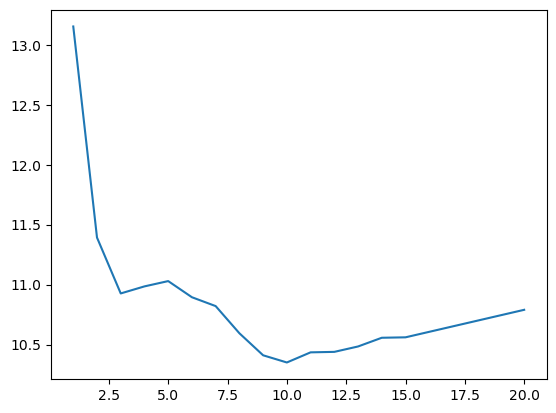

In [124]:
plt.plot(param["n_neighbors"], -knn_reg_optim.cv_results_["mean_test_score"])
plt.show()

In [125]:
# RMSE für das Training und das Test Set aus dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, knn_reg_optim.predict(X_train_reg_wo), squared= False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, knn_reg_optim.predict(X_test_reg_wo), squared= False).round(4))

RMSE (Training): 9.5303
RMSE (Test)    : 10.4483


In [126]:
# Fill data frame with results of final models
df_RMSEs_wo = pd.concat([df_RMSEs_wo, pd.DataFrame(data=[[mean_squared_error(y_train_reg_wo, knn_reg_optim.predict(X_train_reg_wo), squared= False),
                                                          mean_squared_error(y_test_reg_wo, knn_reg_optim.predict(X_test_reg_wo), squared= False)]],
                                                   index=['kNN_wo'], columns=['Training', 'Test'])])
df_RMSEs_wo

,Training,Test
SGD_wo,8.378613,11.114876
kNN_wo,9.530272,10.448291


In [127]:
# Fill data frame with results of final models
df_RMSEs_wo["KNN"] = [mean_squared_error(y_train_reg_wo, knn_reg_optim.predict(X_train_reg_wo), squared= False),
                      mean_squared_error(y_test_reg_wo, knn_reg_optim.predict(X_test_reg_wo), squared= False)]

### Support Vector Machines Regressor

In [128]:
svr_rbf_reg = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1, tol=0.05)
svr_rbf_reg.fit(X_train_reg_wo, y_train_reg_wo)

SVR(C=100, gamma=0.1, tol=0.05)

In [129]:
# RMSE für Training und Test Set auf dem Initalien Modell
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, svr_rbf_reg.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, svr_rbf_reg.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 1.7585
RMSE (Test)    : 10.0722


Zwischen den RMSE Werte des Trainings- bzw. des Test-Sets besteht ein grosser Unterschied. Mit den gewählten Hyperparametern ist das Modell schlecht angepasst.

In [130]:
# Anzahl Iterationen bis Modell konvergiert ist
svr_rbf_reg.n_iter_

892

In [131]:
space = {
    "C": loguniform(1, 1000),
    "gamma": loguniform(0.001, 0.1),
    "epsilon": loguniform(0.01, 1)
}
svr_rbf_reg_optim = RandomizedSearchCV(svr_rbf_reg, space, n_iter=200, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, random_state=random_state, verbose=10)
svr_rbf_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=SVR(C=100, gamma=0.1, tol=0.05), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D1F9A74310>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D18329C3D0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D184EC3B50>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [132]:
# mittlere und totale Berechnungszeit
print("Mittlere Berechnungszeit pro Fit: ", svr_rbf_reg_optim.cv_results_["mean_fit_time"].mean().round(3),"s", sep="")
print("Gesamte Berechnungszeit für alle Fits: ", svr_rbf_reg_optim.cv_results_["mean_fit_time"].sum().round(1), "s", sep="")

Mittlere Berechnungszeit pro Fit: 0.008s
Gesamte Berechnungszeit für alle Fits: 1.5s


In [133]:
print('Best Score: %s' % -svr_rbf_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % svr_rbf_reg_optim.best_params_)

Best Score: 9.904
Best Hyperparameters: {'C': 30.42712468149505, 'epsilon': 0.013035194629380074, 'gamma': 0.012561970368593833}


In [134]:
# SVR Modell mit optimierten Hyperparameter, ohne vorgängige Berechnung der Optimierung
svr_rbf_reg_optim = SVR(kernel="rbf", C=30.4271, gamma=0.01256, epsilon=0.013035, tol=0.05)
svr_rbf_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

SVR(C=30.4271, epsilon=0.013035, gamma=0.01256, tol=0.05)

In [135]:
# RMSE für Training und Test Set auf dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, svr_rbf_reg_optim.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test):    ", mean_squared_error(y_test_reg_wo, svr_rbf_reg_optim.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 8.6562
RMSE (Test):     11.4927


In [136]:
# Fill data frame with results of final models
df_RMSEs_wo = pd.concat([df_RMSEs_wo, pd.DataFrame(data=[[mean_squared_error(y_train_reg_wo, svr_rbf_reg_optim.predict(X_train_reg_wo), squared= False),
                                                          mean_squared_error(y_test_reg_wo, svr_rbf_reg_optim.predict(X_test_reg_wo), squared= False)]],
                                                   index=['SVR_wo'], columns=['Training', 'Test'])])
df_RMSEs_wo

,Training,Test,KNN
SGD_wo,8.378613,11.114876,9.530272
kNN_wo,9.530272,10.448291,10.448291
SVR_wo,8.656150,11.492682,NaN


### Decision Tree Regressor

In [137]:
dtree_reg = DecisionTreeRegressor(max_depth=10, random_state=random_state)
dtree_reg.fit(X_train_reg_wo, y_train_reg_wo)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [138]:
# Cross validation
dtree_reg_rmses = -cross_val_score(dtree_reg, X_train_reg_wo, y_train_reg_wo,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(dtree_reg_rmses).describe()

count    10.000000
mean     13.612675
std       1.223382
min      11.360685
25%      12.988549
50%      13.684761
75%      14.336017
max      15.340570
dtype: float64

In [139]:
# Root Mean Square Error für Training- und Test-Set berechnen und ausgeben
print("RMSE: (Training):", mean_squared_error(y_train_reg_wo, dtree_reg.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE: (Test)    :", mean_squared_error(y_test_reg_wo, dtree_reg.predict(X_test_reg_wo), squared=False).round(4))

RMSE: (Training): 2.9051
RMSE: (Test)    : 13.6666


Der RMSE für das Training-Set ist deutlich tiefer als derjenige für das Test-Set. Dies zeigt sich auch bei der Cross-Validation. Das Modell scheint overfitted zu sein.

In [140]:
 # Random Search Optimierung
space = {
    "max_features": randint(low=2, high=31),
    "max_leaf_nodes": randint(low=2, high=100),
    "max_depth": randint(low=3, high=50)
}
dtree_reg_optim = RandomizedSearchCV(dtree_reg, space, n_iter=100, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1, random_state=random_state)
dtree_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

RandomizedSearchCV(cv=10,
                   estimator=DecisionTreeRegressor(max_depth=10,
                                                   random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D1854CB610>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D1829101F0>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D1829106D0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [141]:
# Parameter des besten Modells
print('Best Score: %s' % -dtree_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % dtree_reg_optim.best_params_)

Best Score: 11.005
Best Hyperparameters: {'max_depth': 35, 'max_features': 17, 'max_leaf_nodes': 24}


In [142]:
# RMSE für Training und Test Set auf dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, dtree_reg_optim.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, dtree_reg_optim.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 7.748
RMSE (Test)    : 13.3424


Der optimierte Decission Tree führt nicht wirklich zu einer verbesserten Vorhersage als beim initalen Modell.

In [143]:
# Fill data frame with results of final models
df_RMSEs_wo = pd.concat([df_RMSEs_wo, pd.DataFrame(data=[[mean_squared_error(y_train_reg_wo, dtree_reg_optim.predict(X_train_reg_wo), squared= False),
                                                          mean_squared_error(y_test_reg_wo, dtree_reg_optim.predict(X_test_reg_wo), squared= False)]],
                                                   index=['dTree_wo'], columns=['Training', 'Test'])])
df_RMSEs_wo

,Training,Test,KNN
SGD_wo,8.378613,11.114876,9.530272
kNN_wo,9.530272,10.448291,10.448291
SVR_wo,8.656150,11.492682,NaN
dTree_wo,7.748049,13.342370,NaN


### Random Forest Regressor

In [144]:
rnd_forest_reg = RandomForestRegressor(random_state=random_state)
rnd_forest_reg.fit(X_train_reg_wo, y_train_reg_wo)

RandomForestRegressor(random_state=42)

In [145]:
# Cross validation
rnd_forest_reg_rmses = -cross_val_score(rnd_forest_reg, X_train_reg_wo, y_train_reg_wo,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(rnd_forest_reg_rmses).describe()

count    10.000000
mean     10.884822
std       1.110170
min       8.984194
25%      10.144051
50%      10.762184
75%      11.538616
max      12.715300
dtype: float64

In [146]:
# Root Mean Square Error für Training- und Test-Set berechnen und ausgeben
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, rnd_forest_reg.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, rnd_forest_reg.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 4.0699
RMSE (Test)    : 9.5316


In [147]:
 # Random Search Optimierung
space = {
    "max_features": randint(low=2, high=31),
    "max_leaf_nodes": randint(low=2, high=100),
    "max_depth": randint(low=3, high=50),
    "n_estimators": randint(low=10, high=200)
}
rnd_forest_reg_optim = RandomizedSearchCV(rnd_forest_reg, space, n_iter=200, scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1, random_state=random_state, verbose=10)
rnd_forest_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D184621C40>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D1829021C0>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D1807C6DC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D1807C6EE0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [148]:
# mittlere und totale Berechnungszeit
print("Mittlere Berechnungszeit pro Fit: ", rnd_forest_reg_optim.cv_results_["mean_fit_time"].mean().round(3),"s", sep="")
print("Gesamte Berechnungszeit für alle Fits: ", rnd_forest_reg_optim.cv_results_["mean_fit_time"].sum().round(1), "s", sep="")

Mittlere Berechnungszeit pro Fit: 0.255s
Gesamte Berechnungszeit für alle Fits: 50.9s


In [149]:
# Parameter des besten Modells
print('Best Score: %s' % -rnd_forest_reg_optim.best_score_.round(3))
print('Best Hyperparameters: %s' % rnd_forest_reg_optim.best_params_)

Best Score: 10.169
Best Hyperparameters: {'max_depth': 19, 'max_features': 10, 'max_leaf_nodes': 34, 'n_estimators': 166}


In [150]:
# Random Forest Modell mit optimierten Hyperparameter, ohne vorgängige, zeitaufwändige Berechnung der Optimierung
rnd_forest_reg_optim = RandomForestRegressor(random_state=random_state, max_features=10, max_depth=19, max_leaf_nodes=34, n_estimators=166)
rnd_forest_reg_optim.fit(X_train_reg_wo, y_train_reg_wo)

RandomForestRegressor(max_depth=19, max_features=10, max_leaf_nodes=34,
                      n_estimators=166, random_state=42)

In [151]:
# RMSE für Training und Test Set auf dem optimierten Modell
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, rnd_forest_reg_optim.predict(X_train_reg_wo), squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, rnd_forest_reg_optim.predict(X_test_reg_wo), squared=False).round(4))

RMSE (Training): 6.4202
RMSE (Test)    : 9.7879


Der RMSE ist sowohl für die Trainings- wie auch für die Test-Daten kleiner geworden. Der unterschied der beiden Werte ist noch immer gross, was auf ein overfitted Modell schliesen lässt.

In [152]:
# Fill data frame with results of final models
df_RMSEs_wo = pd.concat([df_RMSEs_wo, pd.DataFrame(data=[[mean_squared_error(y_train_reg_wo, rnd_forest_reg_optim.predict(X_train_reg_wo), squared= False),
                                                          mean_squared_error(y_test_reg_wo, rnd_forest_reg_optim.predict(X_test_reg_wo), squared= False)]],
                                                   index=['rForest_wo'], columns=['Training', 'Test'])])
df_RMSEs_wo

,Training,Test,KNN
SGD_wo,8.378613,11.114876,9.530272
kNN_wo,9.530272,10.448291,10.448291
SVR_wo,8.656150,11.492682,NaN
dTree_wo,7.748049,13.342370,NaN
rForest_wo,6.420152,9.787920,NaN


### Stacked Model

In [153]:
# Resultate der trainierten Base Learner
df_RMSEs_wo.round(3)

,Training,Test,KNN
SGD_wo,8.379,11.115,9.530
kNN_wo,9.530,10.448,10.448
SVR_wo,8.656,11.493,NaN
dTree_wo,7.748,13.342,NaN
rForest_wo,6.420,9.788,NaN


Das Stacked Model wird aus dem KNN, dem SVR, sowie dem Random Forest Modell zusammengesetzt, welche als Einzelmodelle am besten abgeschnitten haben.

In [154]:
# Stacked Model definieren und trainieren
estimators_wo = [
    ("sgd", SGDRegressor(l1_ratio=0.1, alpha=0.0005, max_iter=10000, tol=0.00001, penalty="elasticnet", eta0=0.01, n_iter_no_change=100, random_state=random_state)),
    ("svr", SVR(kernel="rbf", C=30.4271, gamma=0.01256, epsilon=0.013035, tol=0.05)),
    ("rnd_forest", RandomForestRegressor(random_state=random_state, max_features=10, max_depth=19, max_leaf_nodes=34, n_estimators=166))
]

stacking_reg_wo = StackingRegressor(
    estimators=estimators_wo,
    final_estimator=RidgeCV())
stacking_reg_wo.fit(X_train_reg_wo, y_train_reg_wo)

StackingRegressor(estimators=[('sgd',
                               SGDRegressor(alpha=0.0005, l1_ratio=0.1,
                                            max_iter=10000,
                                            n_iter_no_change=100,
                                            penalty='elasticnet',
                                            random_state=42, tol=1e-05)),
                              ('svr',
                               SVR(C=30.4271, epsilon=0.013035, gamma=0.01256,
                                   tol=0.05)),
                              ('rnd_forest',
                               RandomForestRegressor(max_depth=19,
                                                     max_features=10,
                                                     max_leaf_nodes=34,
                                                     n_estimators=166,
                                                     random_state=42))],
                  final_estimator=RidgeCV())

In [155]:
# Cross validation
stacking_reg_rmses = -cross_val_score(stacking_reg_wo, X_train_reg_wo, y_train_reg_wo,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(stacking_reg_rmses).describe()

count    10.000000
mean     10.069721
std       1.094137
min       8.538522
25%       9.320430
50%      10.105613
75%      10.672277
max      12.207259
dtype: float64

In [156]:
# Vorhergesagte Anteile Ja-Stimmen für Trainings-Daten
y_train_reg_pred_wo = stacking_reg_wo.predict(X_train_reg_wo)

# Vorhergesagte Anteile Ja-Stimmen für Test-Daten
y_test_reg_pred_wo = stacking_reg_wo.predict(X_test_reg_wo)

In [157]:
# Root Mean Square Error für Training- und Test-Set berechnen und ausgeben
print("RMSE (Training):", mean_squared_error(y_train_reg_wo, y_train_reg_pred_wo, squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_wo, y_test_reg_pred_wo, squared=False).round(4))
print("MAE (Test)     :", mean_absolute_error(y_test_reg_wo, y_test_reg_pred_wo).round(3))

RMSE (Training): 7.6839
RMSE (Test)    : 10.6426
MAE (Test)     : 8.037


Das Modell ist overfitted, was daran zu erkennen ist, dass der RMSE der Test-Daten deutlich höher ist als derjenige der Trainings-Daten.

In [158]:
# Fill data frame with results of final models
df_RMSEs_wo = pd.concat([df_RMSEs_wo, pd.DataFrame(data=[[mean_squared_error(y_train_reg_wo, y_train_reg_pred_wo, squared= False),
                                                          mean_squared_error(y_test_reg_wo, y_test_reg_pred_wo, squared= False)]],
                                                   index=['Stacked_wo'], columns=['Training', 'Test'])])
df_RMSEs_wo

,Training,Test,KNN
SGD_wo,8.378613,11.114876,9.530272
kNN_wo,9.530272,10.448291,10.448291
SVR_wo,8.656150,11.492682,NaN
dTree_wo,7.748049,13.342370,NaN
rForest_wo,6.420152,9.787920,NaN
Stacked_wo,7.683900,10.642616,NaN


## Lineare Regression nur "idealtypische" Gemeinden

In [159]:
# Arrays mit unabhängigen und abhängigen Variablen für Regressionsmodelle erstellen
# Arrays mit Trainingsdaten
X_train_reg_ols = np.asarray(train_set[['default__Herzogenbuchsee', 'default__Einsiedeln', 'default__Gambarogno', 'default__Chavornay']])
y_train_reg_ols = np.asarray(train_set['remainder__volkja-proz'])

# Arrays mit Testdaten
X_test_reg_ols = np.asarray(test_set[['default__Herzogenbuchsee', 'default__Einsiedeln', 'default__Gambarogno', 'default__Chavornay']])
y_test_reg_ols = np.asarray(test_set['remainder__volkja-proz'])

In [160]:
# Standardabweichungen der abhängigen Variablen
print("Trainingsdaten: ", np.std(y_train_reg_wo).round(3))
print("Testdaten: ", np.std(y_test_reg_wo).round(3))

Trainingsdaten:  17.645
Testdaten:  16.086


In [161]:
ols = LinearRegression()
ols.fit(X_train_reg_ols, y_train_reg_ols)
ols.coef_

array([11.89527494,  0.85242499,  2.82946245,  2.88288055])

In [162]:
# Vorhergesagte Anteile Ja-Stimmen für Trainings-Daten
y_train_reg_pred_ols = ols.predict(X_train_reg_ols)

# Vorhergesagte Anteile Ja-Stimmen für Test-Daten
y_test_reg_pred_ols = ols.predict(X_test_reg_ols)

In [163]:
# RMSE für Training und Test Set
print("RMSE (Training):", mean_squared_error(y_train_reg_ols, y_train_reg_pred_ols, squared=False).round(4))
print("RMSE (Test)    :", mean_squared_error(y_test_reg_ols, y_test_reg_pred_ols, squared=False).round(4))

RMSE (Training): 2.4104
RMSE (Test)    : 2.5721


In [164]:
# Fill data frame with results of final models
df_RMSEs_ols = pd.DataFrame(data=[[mean_squared_error(y_train_reg_ols, y_train_reg_pred_ols, squared=False),
                                  mean_squared_error(y_test_reg_ols, y_test_reg_pred_ols, squared=False)]],
                           index=['OLS'], columns=['Training', 'Test'])
df_RMSEs_ols

,Training,Test
OLS,2.410449,2.572146


## Resultatübersicht

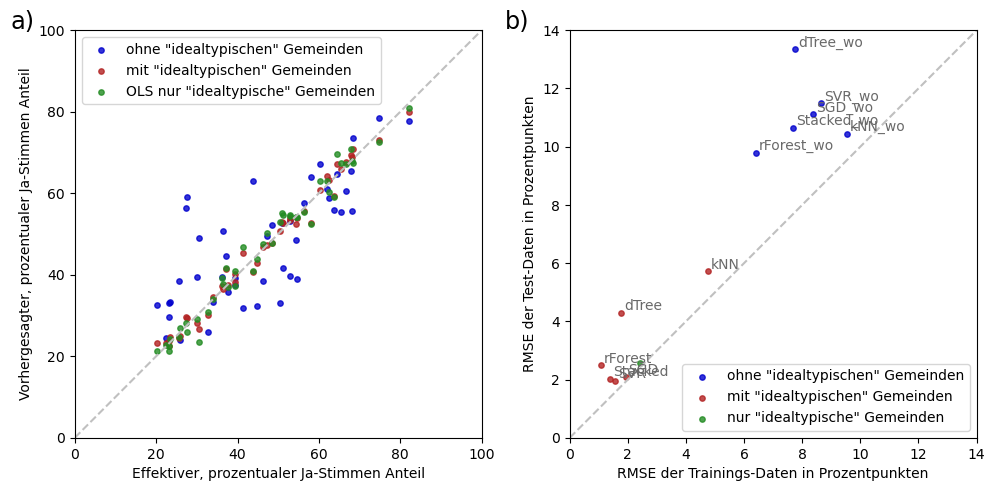

In [165]:
#Plotbereich mit Grösse initialisieren
plt.figure(figsize=[10, 5])

plt.subplot(1, 2, 1)
plt.plot([0, 100], [0, 100], linestyle = 'dashed', color='silver') # 45° Linie einzeichnen
plt.scatter(y_test_reg_wo, y_test_reg_pred_wo, color='mediumblue', label='ohne "idealtypischen" Gemeinden', alpha=0.8, s=15)
plt.scatter(y_test_reg, y_test_reg_pred, color='firebrick', label='mit "idealtypischen" Gemeinden', alpha=0.8, s=15)
plt.scatter(y_test_reg_ols, y_test_reg_pred_ols, color='forestgreen', label='OLS nur "idealtypische" Gemeinden', alpha=0.8, s=15)
plt.legend(loc='upper left')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Effektiver, prozentualer Ja-Stimmen Anteil')
plt.ylabel('Vorhergesagter, prozentualer Ja-Stimmen Anteil')
plt.text(-10, 105, 'a)', horizontalalignment='right', verticalalignment='top', size='xx-large')


plt.subplot(1, 2, 2)
# 45° Linie einzeichnen
plt.plot([0, 15], [0, 15], linestyle = 'dashed', color='silver') # 45° Linie einzeichnen
# Datenpunkte plotten
plt.scatter(data=df_RMSEs_wo, x='Training', y='Test', color='mediumblue', label='ohne "idealtypischen" Gemeinden', alpha=0.8, s=15)
plt.scatter(data=df_RMSEs, x='Training', y='Test', color='firebrick', label='mit "idealtypischen" Gemeinden', alpha=0.8, s=15)
plt.scatter(data=df_RMSEs_ols, x='Training', y='Test', color='forestgreen', label='nur "idealtypische" Gemeinden', alpha=0.8, s=15)


# Label der Datenpunkte hinzufügen
for idx, row in df_RMSEs.reset_index().iterrows():
    plt.text(row['Training']+0.1, row['Test']+0.1, row['index'], color='dimgrey')
for idx, row in df_RMSEs_wo.reset_index().iterrows():
    plt.text(row['Training']+0.1, row['Test']+0.1, row['index'], color='dimgrey')

plt.legend(loc='lower right')
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.xlabel('RMSE der Trainings-Daten in Prozentpunkten')
plt.ylabel('RMSE der Test-Daten in Prozentpunkten')
plt.text(-10*14/100, 105*14/100, 'b)', horizontalalignment='right', verticalalignment='top', size='xx-large')

save_fig('Resultatübersicht')
plt.show()